## import

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from tensorflow import keras
import keras.layers as kl
import itertools
import seaborn as sns
import plotnine as p9

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,explained_variance_score
from sklearn.model_selection import GridSearchCV

## Data

In [3]:
! wget -O genomic_sequence_plus_features_hl_all_tissues.csv "https://docs.google.com/uc?export=download&id=1w_HDUL9o66Kmn_LK7aWet0gccVaOAI5n"

--2021-06-29 04:35:31--  https://docs.google.com/uc?export=download&id=1w_HDUL9o66Kmn_LK7aWet0gccVaOAI5n
Resolving docs.google.com (docs.google.com)... 74.125.31.138, 74.125.31.139, 74.125.31.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.31.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sp93ssrcof6jom8k3rngdrhec1oirh94/1624941300000/03130359425596125025/*/1w_HDUL9o66Kmn_LK7aWet0gccVaOAI5n?e=download [following]
--2021-06-29 04:35:34--  https://doc-14-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sp93ssrcof6jom8k3rngdrhec1oirh94/1624941300000/03130359425596125025/*/1w_HDUL9o66Kmn_LK7aWet0gccVaOAI5n?e=download
Resolving doc-14-2o-docs.googleusercontent.com (doc-14-2o-docs.googleusercontent.com)... 173.194.214.132, 2607:f8b0:400c:c0b::84
Connecting to doc-14-2o-docs.googleusercontent.com (doc-14-2o-docs

In [4]:
tissue_hl = pd.read_csv('genomic_sequence_plus_features_hl_all_tissues.csv', index_col=False)
tissue_hl

,Unnamed: 0,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Hippocampus,Brain_Hypothalamus,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c_1,Brain_Substantia_nigra,Breast_Mammary_Tissue,Cells_EBV_transformed_lymphocytes,Cells_Transformed_fibroblasts,Colon_Sigmoid,Colon_Transverse,Esophagus_Gastroesophageal_Junction,Esophagus_Mucosa,Esophagus_Muscularis,Heart_Atrial_Appendage,Heart_Left_Ventricle,Kidney_Cortex,Liver,Lung,Minor_Salivary_Gland,Muscle_Skeletal,Nerve_Tibial,Ovary,Pancreas,Pituitary,Prostate,...,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,ENST00000000233.5,8.684749,8.367415,8.500491,8.870365,8.785284,9.254435,9.117210,9.132714,8.924813,8.008174,7.776880,8.960726,9.403438,8.820179,8.867279,9.105035,9.378295,8.597430,8.688164,8.511753,9.041760,8.854868,8.829723,8.304922,8.518325,9.015877,8.724514,8.455327,8.318542,8.538311,7.761551,8.403748,8.249509,9.225207,8.684164,7.800899,7.844684,8.046896,8.286558,...,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667
1,ENST00000000412.3,4.286173,4.621703,4.317130,4.744424,4.723253,4.957297,NaN,NaN,5.198270,4.972693,NaN,5.135515,5.493898,NaN,5.453634,5.306214,NaN,4.680830,4.737225,4.275370,4.288250,5.008784,4.925313,4.347712,4.663084,4.514771,4.704702,4.809227,5.017340,5.110027,4.733957,4.086755,4.064342,5.164441,4.380977,4.300280,4.267406,NaN,NaN,...,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271
2,ENST00000000442.6,1.927094,2.666263,2.720771,3.042311,2.916620,3.285028,3.041027,3.180938,2.942831,2.371094,2.513428,3.139064,3.284977,3.206451,2.796171,2.797507,3.321928,3.268625,3.434536,2.052196,1.845102,2.745811,2.754888,2.059008,2.836965,2.742051,2.907843,3.331976,3.832953,3.110679,2.849957,1.955405,2.113458,4.416217,2.313273,2.153723,2.478470,2.599349,2.449079,...,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364
3,ENST00000001008.4,5.158090,4.955507,5.866986,5.258734,5.470043,5.530281,5.790511,5.986519,5.666757,5.214208,4.937500,5.706953,6.343717,5.681103,5.855552,5.762880,5.770074,5.465185,5.757749,4.948113,6.168325,6.467532,5.255815,5.440204,5.475388,5.695586,5.624491,5.211967,5.726818,5.482850,5.373702,4.622685,5.133856,7.042966,4.927550,4.756413,5.302008,4.715045,4.845992,...,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322
4,ENST00000001146.2,3.438673,3.095157,3.643856,2.589955,2.690010,3.571297,4.451311,4.149866,2.727920,4.089405,3.772659,3.861526,4.554589,3.713399,3.914086,3.041027,3.296961,4.159898,2.321928,3.214530,NaN,3.662465

In [5]:
tissue_hl.rename(columns={'Unnamed: 0':'Name'},inplace=True)
tissue_hl

,Name,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Hippocampus,Brain_Hypothalamus,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c_1,Brain_Substantia_nigra,Breast_Mammary_Tissue,Cells_EBV_transformed_lymphocytes,Cells_Transformed_fibroblasts,Colon_Sigmoid,Colon_Transverse,Esophagus_Gastroesophageal_Junction,Esophagus_Mucosa,Esophagus_Muscularis,Heart_Atrial_Appendage,Heart_Left_Ventricle,Kidney_Cortex,Liver,Lung,Minor_Salivary_Gland,Muscle_Skeletal,Nerve_Tibial,Ovary,Pancreas,Pituitary,Prostate,...,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,ENST00000000233.5,8.684749,8.367415,8.500491,8.870365,8.785284,9.254435,9.117210,9.132714,8.924813,8.008174,7.776880,8.960726,9.403438,8.820179,8.867279,9.105035,9.378295,8.597430,8.688164,8.511753,9.041760,8.854868,8.829723,8.304922,8.518325,9.015877,8.724514,8.455327,8.318542,8.538311,7.761551,8.403748,8.249509,9.225207,8.684164,7.800899,7.844684,8.046896,8.286558,...,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667
1,ENST00000000412.3,4.286173,4.621703,4.317130,4.744424,4.723253,4.957297,NaN,NaN,5.198270,4.972693,NaN,5.135515,5.493898,NaN,5.453634,5.306214,NaN,4.680830,4.737225,4.275370,4.288250,5.008784,4.925313,4.347712,4.663084,4.514771,4.704702,4.809227,5.017340,5.110027,4.733957,4.086755,4.064342,5.164441,4.380977,4.300280,4.267406,NaN,NaN,...,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271
2,ENST00000000442.6,1.927094,2.666263,2.720771,3.042311,2.916620,3.285028,3.041027,3.180938,2.942831,2.371094,2.513428,3.139064,3.284977,3.206451,2.796171,2.797507,3.321928,3.268625,3.434536,2.052196,1.845102,2.745811,2.754888,2.059008,2.836965,2.742051,2.907843,3.331976,3.832953,3.110679,2.849957,1.955405,2.113458,4.416217,2.313273,2.153723,2.478470,2.599349,2.449079,...,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364
3,ENST00000001008.4,5.158090,4.955507,5.866986,5.258734,5.470043,5.530281,5.790511,5.986519,5.666757,5.214208,4.937500,5.706953,6.343717,5.681103,5.855552,5.762880,5.770074,5.465185,5.757749,4.948113,6.168325,6.467532,5.255815,5.440204,5.475388,5.695586,5.624491,5.211967,5.726818,5.482850,5.373702,4.622685,5.133856,7.042966,4.927550,4.756413,5.302008,4.715045,4.845992,...,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322
4,ENST00000001146.2,3.438673,3.095157,3.643856,2.589955,2.690010,3.571297,4.451311,4.149866,2.727920,4.089405,3.772659,3.861526,4.554589,3.713399,3.914086,3.041027,3.296961,4.159898,2.321928,3.214530,NaN,3.662465,3.284

In [6]:
# keep mRNAs with annotated 3' and 5' UTRs
tissue_hl = tissue_hl.loc[tissue_hl.loc[:, ['3_utr', '5_utr']].dropna().index]
tissue_hl

,Name,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Hippocampus,Brain_Hypothalamus,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c_1,Brain_Substantia_nigra,Breast_Mammary_Tissue,Cells_EBV_transformed_lymphocytes,Cells_Transformed_fibroblasts,Colon_Sigmoid,Colon_Transverse,Esophagus_Gastroesophageal_Junction,Esophagus_Mucosa,Esophagus_Muscularis,Heart_Atrial_Appendage,Heart_Left_Ventricle,Kidney_Cortex,Liver,Lung,Minor_Salivary_Gland,Muscle_Skeletal,Nerve_Tibial,Ovary,Pancreas,Pituitary,Prostate,...,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,ENST00000000233.5,8.684749,8.367415,8.500491,8.870365,8.785284,9.254435,9.117210,9.132714,8.924813,8.008174,7.776880,8.960726,9.403438,8.820179,8.867279,9.105035,9.378295,8.597430,8.688164,8.511753,9.041760,8.854868,8.829723,8.304922,8.518325,9.015877,8.724514,8.455327,8.318542,8.538311,7.761551,8.403748,8.249509,9.225207,8.684164,7.800899,7.844684,8.046896,8.286558,...,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667
1,ENST00000000412.3,4.286173,4.621703,4.317130,4.744424,4.723253,4.957297,NaN,NaN,5.198270,4.972693,NaN,5.135515,5.493898,NaN,5.453634,5.306214,NaN,4.680830,4.737225,4.275370,4.288250,5.008784,4.925313,4.347712,4.663084,4.514771,4.704702,4.809227,5.017340,5.110027,4.733957,4.086755,4.064342,5.164441,4.380977,4.300280,4.267406,NaN,NaN,...,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271
2,ENST00000000442.6,1.927094,2.666263,2.720771,3.042311,2.916620,3.285028,3.041027,3.180938,2.942831,2.371094,2.513428,3.139064,3.284977,3.206451,2.796171,2.797507,3.321928,3.268625,3.434536,2.052196,1.845102,2.745811,2.754888,2.059008,2.836965,2.742051,2.907843,3.331976,3.832953,3.110679,2.849957,1.955405,2.113458,4.416217,2.313273,2.153723,2.478470,2.599349,2.449079,...,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364
3,ENST00000001008.4,5.158090,4.955507,5.866986,5.258734,5.470043,5.530281,5.790511,5.986519,5.666757,5.214208,4.937500,5.706953,6.343717,5.681103,5.855552,5.762880,5.770074,5.465185,5.757749,4.948113,6.168325,6.467532,5.255815,5.440204,5.475388,5.695586,5.624491,5.211967,5.726818,5.482850,5.373702,4.622685,5.133856,7.042966,4.927550,4.756413,5.302008,4.715045,4.845992,...,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322
4,ENST00000001146.2,3.438673,3.095157,3.643856,2.589955,2.690010,3.571297,4.451311,4.149866,2.727920,4.089405,3.772659,3.861526,4.554589,3.713399,3.914086,3.041027,3.296961,4.159898,2.321928,3.214530,NaN,3.662465,3.284

In [14]:
df = tissue_hl
cols=[col for col in df if col != 'Name']+['Name']
df=df[cols]
tissues = df.columns[:49]
tissues
for i in range (49):  #49
  df=df.rename(columns={tissues[i]:i})
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Name
0,8.684749,8.367415,8.500491,8.870365,8.785284,9.254435,9.117210,9.132714,8.924813,8.008174,7.776880,8.960726,9.403438,8.820179,8.867279,9.105035,9.378295,8.597430,8.688164,8.511753,9.041760,8.854868,8.829723,8.304922,8.518325,9.015877,8.724514,8.455327,8.318542,8.538311,7.761551,8.403748,8.249509,9.225207,8.684164,7.800899,7.844684,8.046896,8.286558,9.064743,...,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,ENST00000000233.5
1,4.286173,4.621703,4.317130,4.744424,4.723253,4.957297,NaN,NaN,5.198270,4.972693,NaN,5.135515,5.493898,NaN,5.453634,5.306214,NaN,4.680830,4.737225,4.275370,4.288250,5.008784,4.925313,4.347712,4.663084,4.514771,4.704702,4.809227,5.017340,5.110027,4.733957,4.086755,4.064342,5.164441,4.380977,4.300280,4.267406,NaN,NaN,4.300629,...,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,ENST00000000412.3
2,1.927094,2.666263,2.720771,3.042311,2.916620,3.285028,3.041027,3.180938,2.942831,2.371094,2.513428,3.139064,3.284977,3.206451,2.796171,2.797507,3.321928,3.268625,3.434536,2.052196,1.845102,2.745811,2.754888,2.059008,2.836965,2.742051,2.907843,3.331976,3.832953,3.110679,2.849957,1.955405,2.113458,4.416217,2.313273,2.153723,2.478470,2.599349,2.449079,1.863777,...,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,ENST00000000442.6
3,5.158090,4.955507,5.866986,5.258734,5.470043,5.530281,5.790511,5.986519,5.666757,5.214208,4.937500,5.706953,6.343717,5.681103,5.855552,5.762880,5.770074,5.465185,5.757749,4.948113,6.168325,6.467532,5.255815,5.440204,5.475388,5.695586,5.624491,5.211967,5.726818,5.482850,5.373702,4.622685,5.133856,7.042966,4.927550,4.756413,5.302008,4.715045,4.845992,4.905785,...,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,ENST00000001008.4
4,3.438673,3.095157,3.643856,2.589955,2.690010,3.571297,4.451311,4.149866,2.727920,4.089405,3.772659,3.861526,4.554589,3.713399,3.914086,3.041027,3.296961,4.159898,2.321928,3.214530,NaN,3.662465,3.284208,3.372647,3.473931,3.332409,3.629357,3.320339,3.041027,3.843465,3.464483,3.523562,3.727920,2.605498,3.959980,3.345775,NaN,3.715791,3.862496,3.329501,...,0.035156,0.025391,0.000000,0.000000,0.023438,0.101562,0.003906,0.000000,0.035156,0.060547,0.011719,0.000000,0.037109,0.015625,0.005859,0.003906,0.048828,0.011719,0.007812,0.000000,0.023438,0.041016,0.000000,0.0,0.015625,0.0,0.005859,0.001953,0.015625,0.007812,0.001953,0.0,0.013672,0.011719,0.000000,0.000000,0.039062,0.011719,0.011719,ENST00000001146.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [15]:
df=pd.melt(df,id_vars=df.columns[49:], value_vars=df.columns[0:49], var_name="tissue",value_name="half_life")
df

,cds,5_utr,3_utr,all,chromosome,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Name,tissue,half_life
0,ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGA...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,CCAGCCAGGGGCAGGCCCCTGATGCCCGGAAGCTCCTGCGTGCATC...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,chr7,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,ENST00000000233.5,0,8.684749
1,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,ATTGCACTTTATATGTCCAGCCTCTTCCTCAGTCCCCCAAACCAAA...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,chr12,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,ENST00000000412.3,0,4.286173
2,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,GGCAAGGGGTGGGACTGGTGGGGGTTCTGGCAGGACCTGCCTAGCA...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,chr11,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,ENST00000000442.6,0,1.927094
3,ATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGG...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,CCCCTCTCCACCAGCCCTACTCCTGCGGCTGCCTGCCCCCCAGTCT...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,chr12,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,ENST00000001008.4,0,5.158090
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...,AGGCAATTTTTTTCCTCCCTCTCTCCGCTCCCCTCGCAGCCTCCAC...,CCCAAGACCCACCCGCCTCAGCCCAGCCCAGGCAGCGGGGTGGTGG...,AGGCAATTTTTTTCCTCCCTCTCTCCGCTC

In [16]:
a=len(df)
df = df.loc[df.loc[:, ['half_life']].dropna().index]
print(len(df)/a)
df

0.9295549210707948


,cds,5_utr,3_utr,all,chromosome,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Name,tissue,half_life
0,ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGA...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,CCAGCCAGGGGCAGGCCCCTGATGCCCGGAAGCTCCTGCGTGCATC...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,chr7,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,ENST00000000233.5,0,8.684749
1,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,ATTGCACTTTATATGTCCAGCCTCTTCCTCAGTCCCCCAAACCAAA...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,chr12,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,ENST00000000412.3,0,4.286173
2,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,GGCAAGGGGTGGGACTGGTGGGGGTTCTGGCAGGACCTGCCTAGCA...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,chr11,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,ENST00000000442.6,0,1.927094
3,ATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGG...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,CCCCTCTCCACCAGCCCTACTCCTGCGGCTGCCTGCCCCCCAGTCT...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,chr12,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,ENST00000001008.4,0,5.158090
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...,AGGCAATTTTTTTCCTCCCTCTCTCCGCTCCCCTCGCAGCCTCCAC...,CCCAAGACCCACCCGCCTCAGCCCAGCCCAGGCAGCGGGGTGGTGG...,AGGCAATTTTTTTCCTCCCTCTCTCCGCTC

In [49]:
df1 = df
df1= df1.drop(columns=['cds','3_utr', '5_utr','all','chromosome','Name'])

X = df1.drop(['half_life'], axis=1)
y = df1['half_life']

chrom_val=['chr2', 'chr3','chr4']
chrom_test=['chr1','chr8','chr9']


X_train = X[~(df.chromosome.isin(chrom_test)| df.chromosome.isin(chrom_val))]
X_test  = X[df.chromosome.isin(chrom_test)]
X_val   = X[df.chromosome.isin(chrom_val)]
y_train = y[~(df.chromosome.isin(chrom_test)| df.chromosome.isin(chrom_val))]
y_test  = y[df.chromosome.isin(chrom_test)]
y_val   = y[df.chromosome.isin(chrom_val)]

In [50]:
print(X_train.shape)
print(len(y_train))

print(X_val.shape)
print(len(y_val))

print(X_test.shape)
print(len(y_test))

(332050, 71)
332050
(78770, 71)
78770
(91531, 71)
91531


In [51]:
from sklearn.ensemble import RandomForestRegressor

def train(i):   
    model = RandomForestRegressor(max_depth=20)

    idx_tr= np.where(X_train['tissue'] == i)[0]
    X_tr=np.array(X_train)[idx_tr]
    y_tr=np.array(y_train)[idx_tr]


    idx_te= np.where(X_test['tissue'] == i)[0]
    X_te=np.array(X_test)[idx_te]
    y_te=np.array(y_test)[idx_te]


    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    exp=explained_variance_score(y_te, y_pred)
    print("explained_variance_score",exp)

    msqe = mean_squared_error(y_te,y_pred,squared=False)
    print("mean squared error",msqe)

    return exp, msqe

results_explained_variance = []
results_rmse=[]

for i in range(49):
    print(i,'*************',tissues[i])
    res1, res2= train(i)
    results_explained_variance.append(res1)
    results_rmse.append(res2)

0 ************* Adipose_Subcutaneous
explained_variance_score 0.12903793266418073
mean squared error 2.119270071426745
1 ************* Adipose_Visceral_Omentum
explained_variance_score 0.12323053988224208
mean squared error 2.077634405748777
2 ************* Adrenal_Gland
explained_variance_score 0.09275582687512052
mean squared error 2.0685290998585972
3 ************* Artery_Aorta
explained_variance_score 0.12338731261963798
mean squared error 2.1687073305295033
4 ************* Artery_Coronary
explained_variance_score 0.11285277562734253
mean squared error 2.156612800547088
5 ************* Artery_Tibial
explained_variance_score 0.11417226778576539
mean squared error 2.21484964647639
6 ************* Brain_Amygdala
explained_variance_score 0.11353658510192788
mean squared error 2.1609341363061554
7 ************* Brain_Anterior_cingulate_cortex_BA24
explained_variance_score 0.11385500110549984
mean squared error 2.181352922138596
8 ************* Brain_Caudate_basal_ganglia
explained_varia

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


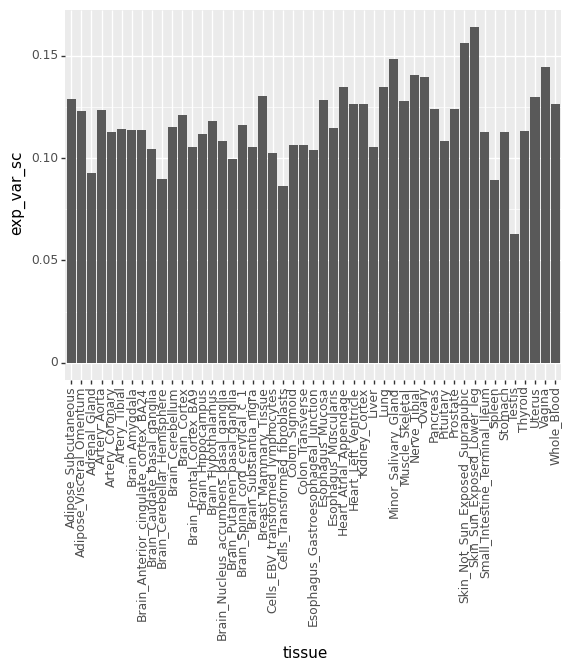

<ggplot: (8781274614125)>

In [52]:
res1 = {'exp_var_sc':results_explained_variance,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


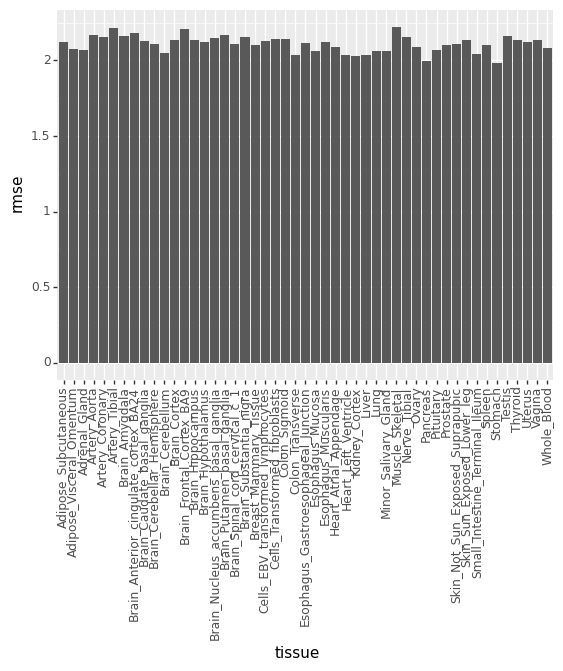

<ggplot: (8781306690649)>

In [53]:
res2 = {'rmse':results_rmse,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))


## Relative Half Life

In [56]:
tissue_hl2=tissue_hl
tissue_hl2['mean_hl'] = tissue_hl2.loc[:, tissues].mean(axis=1)
tissue_hl2

tissue_hl2.loc[:, tissues] = tissue_hl2.loc[:, tissues].sub(tissue_hl2['mean_hl'], axis=0)

df2 = tissue_hl2
cols=[col for col in df2 if col != 'Name']+['Name']
df2=df2[cols]
tissues = df2.columns[:49]
tissues
for i in range (49):  #49
  df2=df2.rename(columns={tissues[i]:i})
df2


df2=pd.melt(df2,id_vars=df2.columns[49:], value_vars=df2.columns[0:49], var_name="tissue",value_name="relative_half_life")
df2

a=len(df2)
df2 = df2.loc[df2.loc[:, ['relative_half_life']].dropna().index]
print(len(df2)/a)
df2


0.9295549210707948


,cds,5_utr,3_utr,all,chromosome,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,mean_hl,Name,tissue,relative_half_life
0,ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGA...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,CCAGCCAGGGGCAGGCCCCTGATGCCCGGAAGCTCCTGCGTGCATC...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,chr7,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,3.842731e-15,ENST00000000233.5,0,0.134752
1,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,ATTGCACTTTATATGTCCAGCCTCTTCCTCAGTCCCCCAAACCAAA...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,chr12,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,1.797504e-16,ENST00000000412.3,0,-0.376770
2,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,GGCAAGGGGTGGGACTGGTGGGGGTTCTGGCAGGACCTGCCTAGCA...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,chr11,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,2.945490e-16,ENST00000000442.6,0,-0.726338
3,ATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGG...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,CCCCTCTCCACCAGCCCTACTCCTGCGGCTGCCTGCCCCCCAGTCT...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,chr12,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,1.631348e-16,ENST00000001008.4,0,-0.216329
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...,AGGCAATTTTTTTCCTCCCTCTCTCCGCTCCCCTCGCAGCCTCCAC...,CCCAAGAC

In [57]:
df3 = df2
df3 = df2.drop(columns=['cds','3_utr', '5_utr','all','chromosome','Name'])

X = df3.drop(['relative_half_life'], axis=1)
y = df3['relative_half_life']

chrom_val=['chr2', 'chr3','chr4']
chrom_test=['chr1','chr8','chr9']


X_train = X[~(df2.chromosome.isin(chrom_test)| df2.chromosome.isin(chrom_val))]
X_test  = X[df2.chromosome.isin(chrom_test)]
X_val   = X[df2.chromosome.isin(chrom_val)]
y_train = y[~(df2.chromosome.isin(chrom_test)| df2.chromosome.isin(chrom_val))]
y_test  = y[df2.chromosome.isin(chrom_test)]
y_val   = y[df2.chromosome.isin(chrom_val)]

In [69]:
from sklearn.ensemble import RandomForestRegressor

def train(i):   
    model = RandomForestRegressor(max_depth=15)

    idx_tr= np.where(X_train['tissue'] == i)[0]
    X_tr=np.array(X_train)[idx_tr]
    y_tr=np.array(y_train)[idx_tr]
    print("train", X_tr.shape)

    idx_te= np.where(X_test['tissue'] == i)[0]
    X_te=np.array(X_test)[idx_te]
    y_te=np.array(y_test)[idx_te]
    print("test", X_te.shape)

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    exp=explained_variance_score(y_te, y_pred)
    print("explained_variance_score for testing set",exp)

    msqe = mean_squared_error(y_te,y_pred,squared=False)
    print("mean squared error for testing set",msqe)

    y_pred2 = model.predict(X_tr)

    exp2=explained_variance_score(y_tr, y_pred2)
    print("explained_variance_score for training set",exp2)

    msqe2 = mean_squared_error(y_tr,y_pred2,squared=False)
    print("mean squared error for training set",msqe2)

    return exp, msqe, exp2, msqe2

results_explained_variance_te = []
results_rmse_te=[]

results_explained_variance_tr = []
results_rmse_tr=[]

for i in range(49):
    print(i,'*************',tissues[i])
    res1, res2, res3, res4= train(i)
    results_explained_variance_te.append(res1)
    results_rmse_te.append(res2)
    results_explained_variance_tr.append(res3)
    results_rmse_tr.append(res4)

0 ************* Adipose_Subcutaneous
train (7071, 72)
test (1955, 72)
explained_variance_score for testing set 0.02864342342043502
mean squared error for testing set 0.5178128206308719
explained_variance_score for training set 0.6608753337774222
mean squared error for training set 0.3123356976838313
1 ************* Adipose_Visceral_Omentum
train (7111, 72)
test (1952, 72)
explained_variance_score for testing set 0.02208439808538787
mean squared error for testing set 0.5069272992418
explained_variance_score for training set 0.5878924511669656
mean squared error for training set 0.32619384823823455
2 ************* Adrenal_Gland
train (6906, 72)
test (1895, 72)
explained_variance_score for testing set 0.05099436709842142
mean squared error for testing set 0.5690106143042015
explained_variance_score for training set 0.694991210410223
mean squared error for training set 0.3102052293099955
3 ************* Artery_Aorta
train (6985, 72)
test (1913, 72)
explained_variance_score for testing set 

explained variance on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


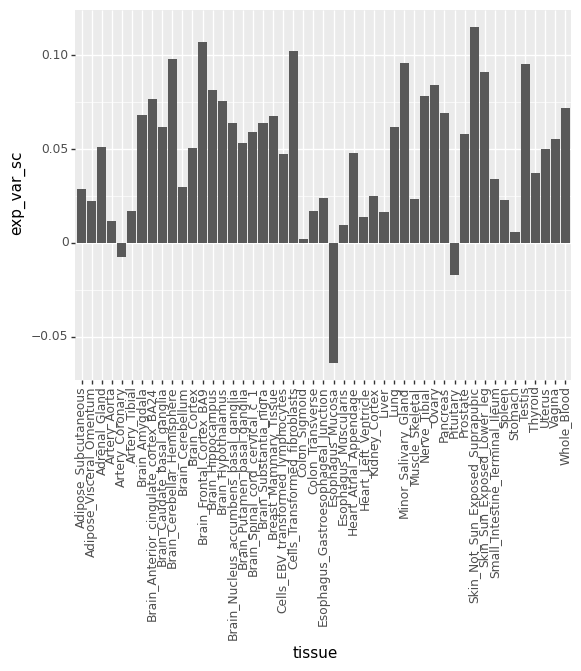

<ggplot: (8781252395405)>

In [70]:
print("explained variance on test set")
res1 = {'exp_var_sc':results_explained_variance_te,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

explained variance on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


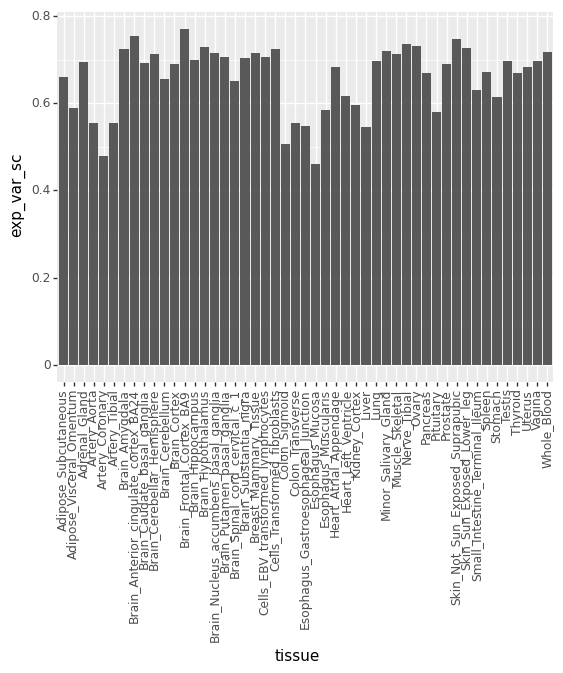

<ggplot: (8781248774829)>

In [71]:
print("explained variance on train set")
res1 = {'exp_var_sc':results_explained_variance_tr,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

root mean squared error on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


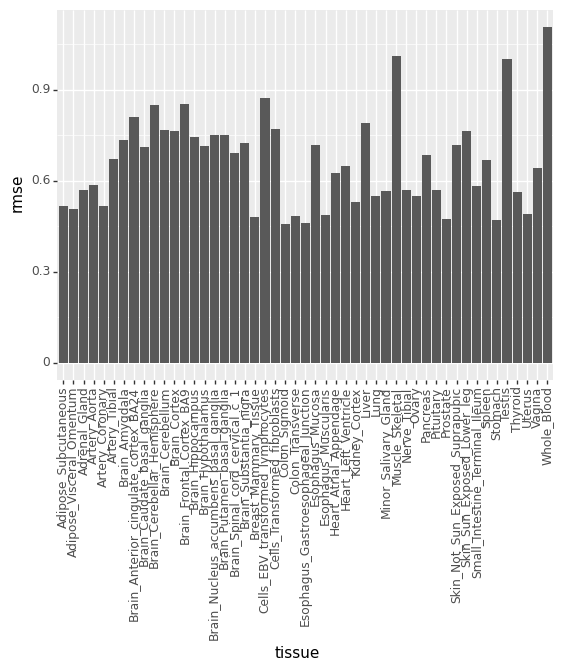

<ggplot: (8781288117745)>

In [72]:
print("root mean squared error on test set")
res2 = {'rmse':results_rmse_te,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))


root mean squared error on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


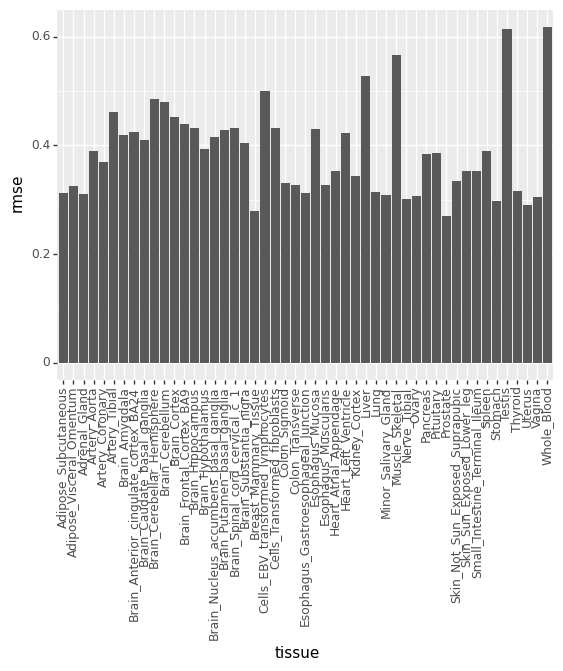

<ggplot: (8781314834049)>

In [73]:
print("root mean squared error on train set")
res2 = {'rmse':results_rmse_tr,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))


## Folding Energy:

In [83]:
utr_3_txt=pd.read_csv('sample_data/hgTables_3utr', delimiter='\t')
utr_3_txt = utr_3_txt.loc[utr_3_txt.loc[:, ['#name','energy']].dropna().index]
utr_3_txt.rename(columns={'energy':'energy_3utr'},inplace=True)

#utr_3_txt=utr_3_txt.drop_duplicates(subset=["#name"])

utr_3_txt.rename(columns={'#name':'Name'},inplace=True)
utr_3_txt=utr_3_txt.drop(['seq','fold'], axis=1)
utr_3_txt


,Name,energy_3utr
0,ENST00000000233.10,-168.3
1,ENST00000000412.8,-393.6
2,ENST00000000442.11,-332.9
3,ENST00000001008.6,-673.5
4,ENST00000001146.6,-1142.8
...,...,...
4399,ENST00000268389.6,-725.2
4400,ENST00000268459.6,-5476.1
4401,ENST00000268482.8,-149.3
4402,ENST00000268483.8,-574.7


In [84]:
utr_5_txt=pd.read_csv('sample_data/hgTables_5utr', delimiter='\t')
utr_5_txt = utr_5_txt.loc[utr_5_txt.loc[:, ['#name','energy']].dropna().index]
utr_5_txt.rename(columns={'energy':'energy_5utr'},inplace=True)

utr_5_txt.rename(columns={'#name':'Name'},inplace=True)


utr_5_txt.rename(columns={'#name':'Name'},inplace=True)
utr_5_txt=utr_5_txt.drop(['seq','fold'], axis=1)
utr_5_txt

,Name,energy_5utr
0,ENST00000000233.10,-30.6
1,ENST00000000412.8,-64.6
2,ENST00000000442.11,-125.5
3,ENST00000001008.6,-74.2
4,ENST00000001146.6,-54.8
...,...,...
28580,ENST00000409557.5,-74.3
28581,ENST00000409558.8,-84.1
28582,ENST00000409560.1,-121.1
28583,ENST00000409561.1,-36.7


In [90]:
tissue_hl_E= tissue_hl
tissue_hl_E= pd.concat([tissue_hl_E,utr_3_txt['energy_3utr']],axis=1,join='inner')

tissue_hl_E= pd.concat([tissue_hl_E,utr_5_txt['energy_5utr']],axis=1,join='inner')
tissue_hl_E

,Name,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Hippocampus,Brain_Hypothalamus,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c_1,Brain_Substantia_nigra,Breast_Mammary_Tissue,Cells_EBV_transformed_lymphocytes,Cells_Transformed_fibroblasts,Colon_Sigmoid,Colon_Transverse,Esophagus_Gastroesophageal_Junction,Esophagus_Mucosa,Esophagus_Muscularis,Heart_Atrial_Appendage,Heart_Left_Ventricle,Kidney_Cortex,Liver,Lung,Minor_Salivary_Gland,Muscle_Skeletal,Nerve_Tibial,Ovary,Pancreas,Pituitary,Prostate,...,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,mean_hl,energy_3utr,energy_5utr
0,ENST00000000233.5,0.134752,-0.182582,-0.049505,0.320368,0.235287,0.704439,0.567214,0.582717,0.374816,-0.541823,-0.773116,0.410729,0.853442,0.270182,0.317282,0.555039,0.828298,0.047433,0.138168,-0.038244,0.491763,0.304871,0.279726,-0.245075,-0.031672,0.465880,0.174517,-0.094669,-0.231454,-0.011686,-0.788445,-0.146249,-0.300488,0.675210,0.134167,-0.749097,-0.705312,-0.503100,-0.263439,...,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,3.842731e-15,-168.3,-30.6
1,ENST00000000412.3,-0.376770,-0.041240,-0.345812,0.081481,0.060310,0.294355,NaN,NaN,0.535327,0.309750,NaN,0.472572,0.830955,NaN,0.790691,0.643271,NaN,0.017888,0.074283,-0.387573,-0.374692,0.345841,0.262371,-0.315230,0.000142,-0.148172,0.041759,0.146285,0.354397,0.447085,0.071014,-0.576187,-0.598600,0.501499,-0.281965,-0.362663,-0.395537,NaN,NaN,...,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,1.797504e-16,-393.6,-64.6
2,ENST00000000442.6,-0.726338,0.012830,0.067338,0.388878,0.263188,0.631595,0.387595,0.527506,0.289399,-0.282338,-0.140004,0.485632,0.631545,0.553018,0.142739,0.144075,0.668496,0.615192,0.781104,-0.601236,-0.808331,0.092379,0.101455,-0.594424,0.183532,0.088619,0.254410,0.678544,1.179520,0.457246,0.196525,-0.698028,-0.539974,1.762785,-0.340159,-0.499709,-0.174962,-0.054084,-0.204353,...,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,2.945490e-16,-332.9,-125.5
3,ENST00000001008.4,-0.216329,-0.418912,0.492567,-0.115684,0.095624,0.155862,0.416093,0.612101,0.292338,-0.160211,-0.436918,0.332534,0.969298,0.306685,0.481134,0.388462,0.395655,0.090767,0.383330,-0.426305,0.793906,1.093114,-0.118603,0.065785,0.100969,0.321167,0.250072,-0.162452,0.352400,0.108432,-0.000717,-0.751734,-0.240563,1.668548,-0.446868,-0.618006,-0.072411,-0.659373,-0.528427,...,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,1.631348e-16,-673.5,-74.2
4,ENST00000001146.2,-0.069316,-0.412832,0.135867,-0.918034,-0.817979,0.063308,0.943322,0.641877,-0.780068,0.581416,0.264670,0.353537,1.046600,0

In [91]:
df3 = tissue_hl_E
cols=[col for col in df3 if col != 'Name']+['Name']
df3=df3[cols]
tissues = df3.columns[:49]
tissues
for i in range (49):  #49
  df3=df3.rename(columns={tissues[i]:i})

df3=pd.melt(df3,id_vars=df3.columns[49:], value_vars=df3.columns[0:49], var_name="tissue",value_name="half_life")
a=len(df3)
df3 = df3.loc[df3.loc[:, ['half_life']].dropna().index]
print(len(df3)/a)
df3

0.9404667944525876


,cds,5_utr,3_utr,all,chromosome,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,...,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,mean_hl,energy_3utr,energy_5utr,Name,tissue,half_life
0,ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGA...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,CCAGCCAGGGGCAGGCCCCTGATGCCCGGAAGCTCCTGCGTGCATC...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,chr7,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,...,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,3.842731e-15,-168.3,-30.6,ENST00000000233.5,0,0.134752
1,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,ATTGCACTTTATATGTCCAGCCTCTTCCTCAGTCCCCCAAACCAAA...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,chr12,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,...,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,1.797504e-16,-393.6,-64.6,ENST00000000412.3,0,-0.376770
2,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,GGCAAGGGGTGGGACTGGTGGGGGTTCTGGCAGGACCTGCCTAGCA...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,chr11,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,...,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,2.945490e-16,-332.9,-125.5,ENST00000000442.6,0,-0.726338
3,ATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGG...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,CCCCTCTCCACCAGCCCTACTCCTGCGGCTGCCTGCCCCCCAGTCT...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,chr12,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,...,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,1.631348e-16,-673.5,-74.2,ENST00000001008.4,0,-0.216329
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...,AGGCAATTTT

In [92]:
df4 = df3.drop(columns=['cds','3_utr', '5_utr','all','chromosome','Name'])

X = df4.drop(['half_life'], axis=1)
y = df4['half_life']

chrom_val=['chr2', 'chr3','chr4']
chrom_test=['chr1','chr8','chr9']


X_train = X[~(df3.chromosome.isin(chrom_test)| df3.chromosome.isin(chrom_val))]
X_test  = X[df3.chromosome.isin(chrom_test)]
X_val   = X[df3.chromosome.isin(chrom_val)]
y_train = y[~(df3.chromosome.isin(chrom_test)| df3.chromosome.isin(chrom_val))]
y_test  = y[df3.chromosome.isin(chrom_test)]
y_val   = y[df3.chromosome.isin(chrom_val)]

0 ************* Adipose_Subcutaneous
train (2919, 74)
test (511, 74)


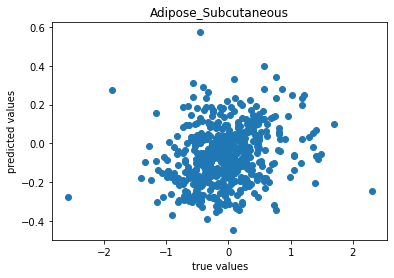

explained_variance_score for testing set 0.041009182063215466
mean squared error for testing set 0.5180060348820986
explained_variance_score for training set 0.8474155428325338
mean squared error for training set 0.20594119988512552
1 ************* Adipose_Visceral_Omentum
train (2930, 74)
test (512, 74)


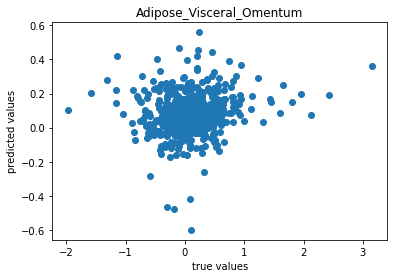

explained_variance_score for testing set 0.001987691527706281
mean squared error for testing set 0.49209219649218844
explained_variance_score for training set 0.8180167284823371
mean squared error for training set 0.21997870064551286
2 ************* Adrenal_Gland
train (2859, 74)
test (494, 74)


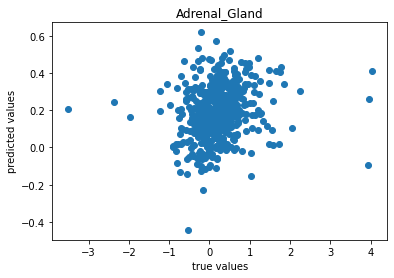

explained_variance_score for testing set 0.03475449889193949
mean squared error for testing set 0.6219118358504169
explained_variance_score for training set 0.8533342358404273
mean squared error for training set 0.2116734993698508
3 ************* Artery_Aorta
train (2881, 74)
test (504, 74)


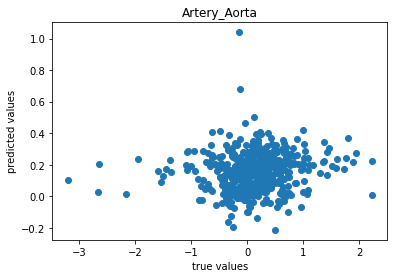

explained_variance_score for testing set -0.0023668520341910693
mean squared error for testing set 0.5975527655127696
explained_variance_score for training set 0.805338457537357
mean squared error for training set 0.2601668201565995
4 ************* Artery_Coronary
train (2919, 74)
test (510, 74)


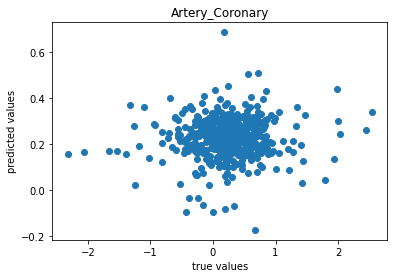

explained_variance_score for testing set -0.00514915957036699
mean squared error for testing set 0.5223308003740007
explained_variance_score for training set 0.7497042077384406
mean squared error for training set 0.25661676797557853
5 ************* Artery_Tibial
train (2903, 74)
test (506, 74)


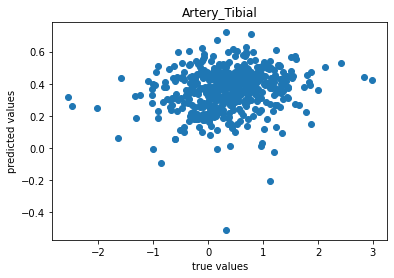

explained_variance_score for testing set 0.02858970414665929
mean squared error for testing set 0.6702319969381286
explained_variance_score for training set 0.7939121492497476
mean squared error for training set 0.312253384246489
6 ************* Brain_Amygdala
train (2694, 74)
test (485, 74)


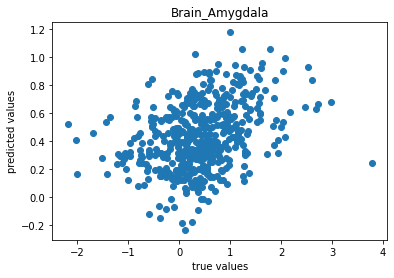

explained_variance_score for testing set 0.12290037290248501
mean squared error for testing set 0.718444971079602
explained_variance_score for training set 0.8561177649439
mean squared error for training set 0.3017863298651803
7 ************* Brain_Anterior_cingulate_cortex_BA24
train (2730, 74)
test (488, 74)


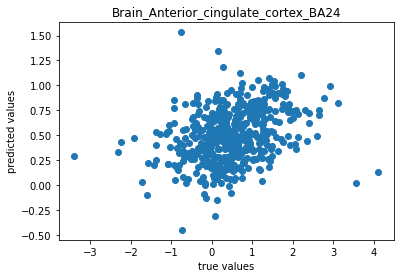

explained_variance_score for testing set 0.09665050034920997
mean squared error for testing set 0.8189265465146931
explained_variance_score for training set 0.8617533879774134
mean squared error for training set 0.32196630086341677
8 ************* Brain_Caudate_basal_ganglia
train (2756, 74)
test (490, 74)


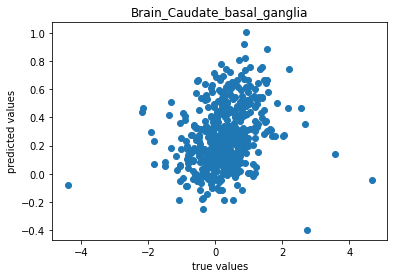

explained_variance_score for testing set 0.06834760484558333
mean squared error for testing set 0.7387585081127854
explained_variance_score for training set 0.8448825014178946
mean squared error for training set 0.2908704222666765
9 ************* Brain_Cerebellar_Hemisphere
train (2608, 74)
test (474, 74)


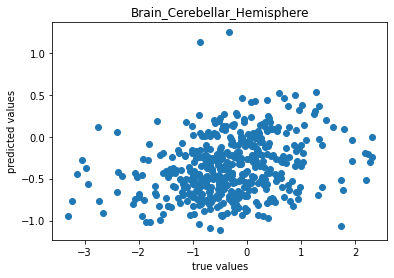

explained_variance_score for testing set 0.06313108442956139
mean squared error for testing set 0.8745136754129131
explained_variance_score for training set 0.8599854955378758
mean squared error for training set 0.3384351724972274
10 ************* Brain_Cerebellum
train (2634, 74)
test (476, 74)


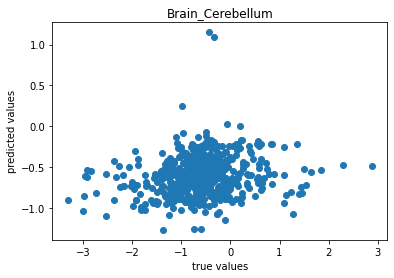

explained_variance_score for testing set 0.014955524318390756
mean squared error for testing set 0.797446263902727
explained_variance_score for training set 0.8492372142854787
mean squared error for training set 0.3155588099871921
11 ************* Brain_Cortex
train (2744, 74)
test (493, 74)


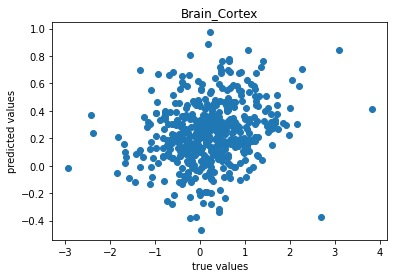

explained_variance_score for testing set 0.051326769299069874
mean squared error for testing set 0.7670707779211263
explained_variance_score for training set 0.8539760111728408
mean squared error for training set 0.31417971255797117
12 ************* Brain_Frontal_Cortex_BA9
train (2751, 74)
test (493, 74)


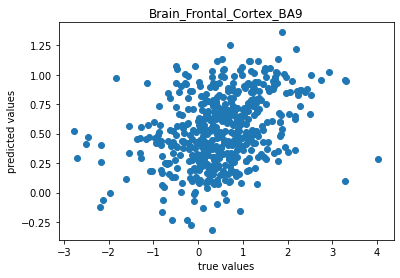

explained_variance_score for testing set 0.12429135461245766
mean squared error for testing set 0.8756433745880681
explained_variance_score for training set 0.8642888201209986
mean squared error for training set 0.33958097570085544
13 ************* Brain_Hippocampus
train (2740, 74)
test (494, 74)


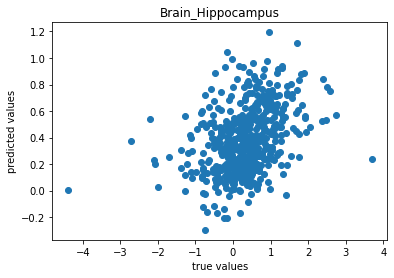

explained_variance_score for testing set 0.13002965932884125
mean squared error for testing set 0.7354632329641503
explained_variance_score for training set 0.8590913711774024
mean squared error for training set 0.2926651319625031
14 ************* Brain_Hypothalamus
train (2764, 74)
test (495, 74)


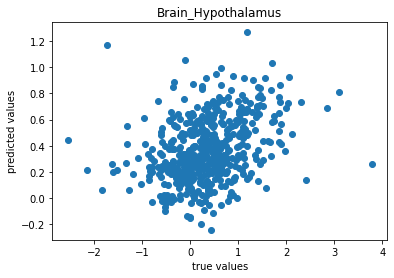

explained_variance_score for testing set 0.11477028158205138
mean squared error for testing set 0.7067633360926051
explained_variance_score for training set 0.8513550667424937
mean squared error for training set 0.29589309525546115
15 ************* Brain_Nucleus_accumbens_basal_ganglia
train (2733, 74)
test (494, 74)


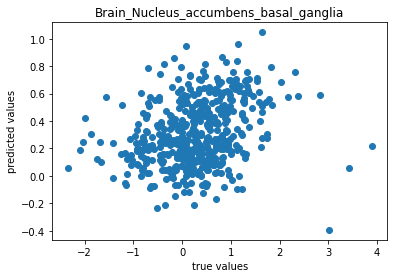

explained_variance_score for testing set 0.07190113216241845
mean squared error for testing set 0.7518456526765799
explained_variance_score for training set 0.8494965493585407
mean squared error for training set 0.30252255406148293
16 ************* Brain_Putamen_basal_ganglia
train (2674, 74)
test (476, 74)


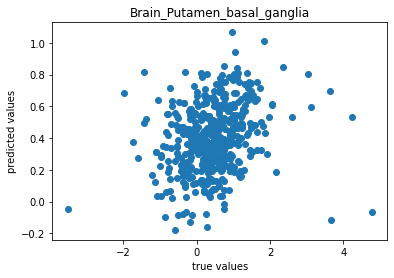

explained_variance_score for testing set 0.06509564730199358
mean squared error for testing set 0.7843632845584448
explained_variance_score for training set 0.8434260658605364
mean squared error for training set 0.3099454257496409
17 ************* Brain_Spinal_cord_cervical_c_1
train (2800, 74)
test (498, 74)


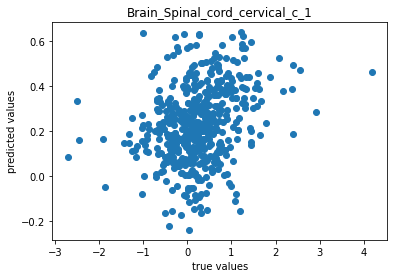

explained_variance_score for testing set 0.07402994109943983
mean squared error for testing set 0.6959386466501578
explained_variance_score for training set 0.8329440567104256
mean squared error for training set 0.29369345969239363
18 ************* Brain_Substantia_nigra
train (2762, 74)
test (490, 74)


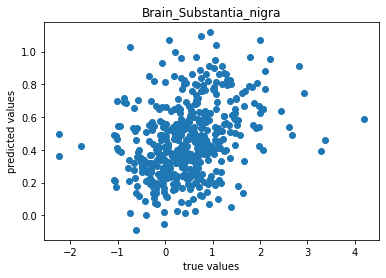

explained_variance_score for testing set 0.09997052569640241
mean squared error for testing set 0.7208415425582643
explained_variance_score for training set 0.8563580439093744
mean squared error for training set 0.27711925930070386
19 ************* Breast_Mammary_Tissue
train (2945, 74)
test (510, 74)


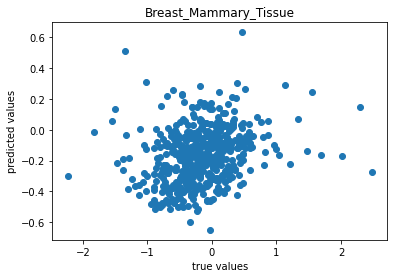

explained_variance_score for testing set 0.04744793788050139
mean squared error for testing set 0.5043858806960796
explained_variance_score for training set 0.8524213704760337
mean squared error for training set 0.2065113039631096
20 ************* Cells_EBV_transformed_lymphocytes
train (2460, 74)
test (412, 74)


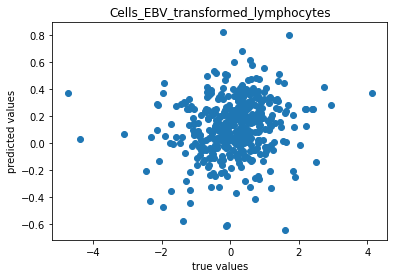

explained_variance_score for testing set 0.024498154161296748
mean squared error for testing set 0.9589712344303439
explained_variance_score for training set 0.8509920398768968
mean squared error for training set 0.34418095086600803
21 ************* Cells_Transformed_fibroblasts
train (2633, 74)
test (468, 74)


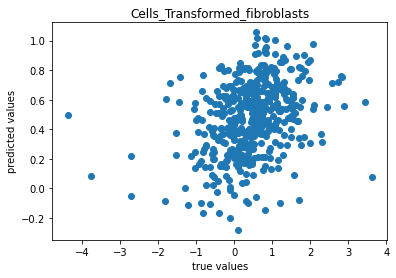

explained_variance_score for testing set 0.10884312617441505
mean squared error for testing set 0.8261054738866003
explained_variance_score for training set 0.8566219311071068
mean squared error for training set 0.3116062533247676
22 ************* Colon_Sigmoid
train (2918, 74)
test (512, 74)


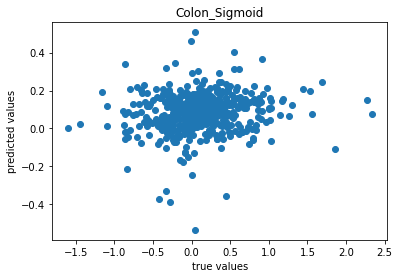

explained_variance_score for testing set 0.009615010070702756
mean squared error for testing set 0.4722834692862863
explained_variance_score for training set 0.7891302766356395
mean squared error for training set 0.2209054398046224
23 ************* Colon_Transverse
train (2925, 74)
test (513, 74)


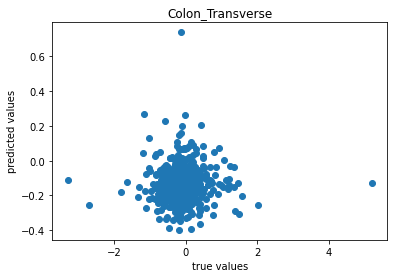

explained_variance_score for testing set -0.028118540639148426
mean squared error for testing set 0.5589788644550044
explained_variance_score for training set 0.789741955026203
mean squared error for training set 0.23073658293484775
24 ************* Esophagus_Gastroesophageal_Junction
train (2924, 74)
test (512, 74)


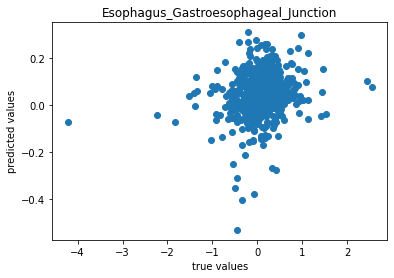

explained_variance_score for testing set 0.03208463430912223
mean squared error for testing set 0.5037158789705842
explained_variance_score for training set 0.7735870383312128
mean squared error for training set 0.22561080450014548
25 ************* Esophagus_Mucosa
train (2885, 74)
test (504, 74)


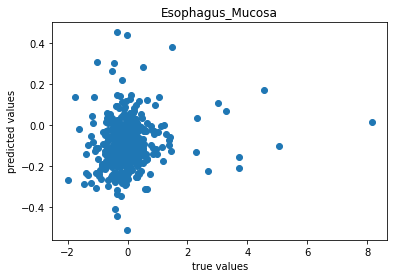

explained_variance_score for testing set 0.01840031562970479
mean squared error for testing set 0.7672091555707499
explained_variance_score for training set 0.7570170203034836
mean squared error for training set 0.304329290231473
26 ************* Esophagus_Muscularis
train (2923, 74)
test (511, 74)


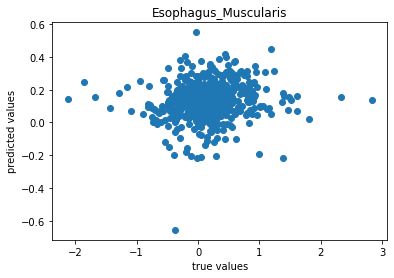

explained_variance_score for testing set -0.0014709974805908743
mean squared error for testing set 0.509321611180528
explained_variance_score for training set 0.8013540452077949
mean squared error for training set 0.2379062590242763
27 ************* Heart_Atrial_Appendage
train (2822, 74)
test (494, 74)


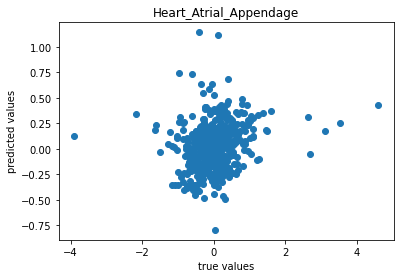

explained_variance_score for testing set 0.029762110959741905
mean squared error for testing set 0.6230966940281805
explained_variance_score for training set 0.8441142304408692
mean squared error for training set 0.2657947990362361
28 ************* Heart_Left_Ventricle
train (2719, 74)
test (489, 74)


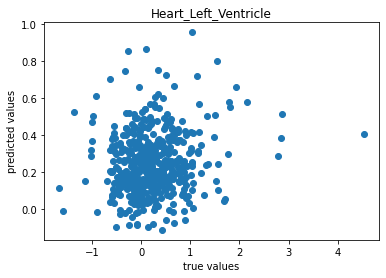

explained_variance_score for testing set 0.0036735944428967215
mean squared error for testing set 0.6088985162869742
explained_variance_score for training set 0.8381139681305796
mean squared error for training set 0.2923884578489456
29 ************* Kidney_Cortex
train (2797, 74)
test (492, 74)


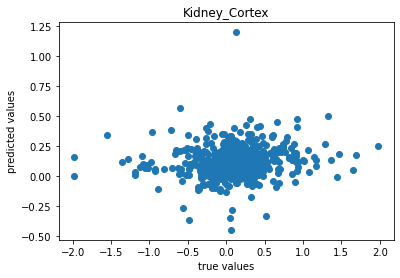

explained_variance_score for testing set 0.0012771566061198225
mean squared error for testing set 0.48146039735974483
explained_variance_score for training set 0.8127482189144458
mean squared error for training set 0.23871238744396595
30 ************* Liver
train (2610, 74)
test (452, 74)


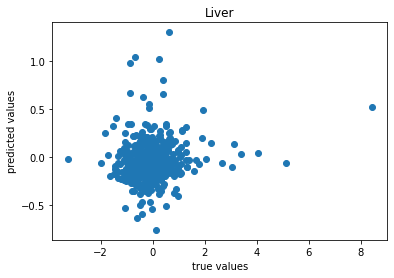

explained_variance_score for testing set 0.0067190694148295815
mean squared error for testing set 0.878682148817932
explained_variance_score for training set 0.8172462173413221
mean squared error for training set 0.3384477154122143
31 ************* Lung
train (2917, 74)
test (510, 74)


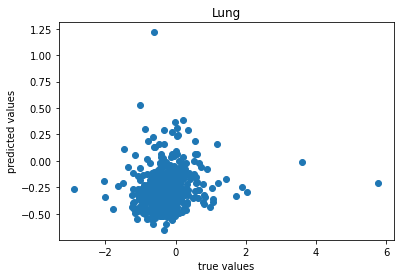

explained_variance_score for testing set -0.008498506201101153
mean squared error for testing set 0.602551488077263
explained_variance_score for training set 0.8488462001380195
mean squared error for training set 0.22390520468583797
32 ************* Minor_Salivary_Gland
train (2867, 74)
test (499, 74)


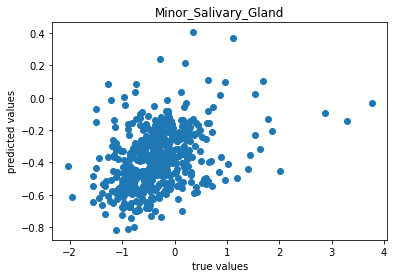

explained_variance_score for testing set 0.12169755379621627
mean squared error for testing set 0.6011199365722476
explained_variance_score for training set 0.8393707230171554
mean squared error for training set 0.25044530976122126
33 ************* Muscle_Skeletal
train (2726, 74)
test (485, 74)


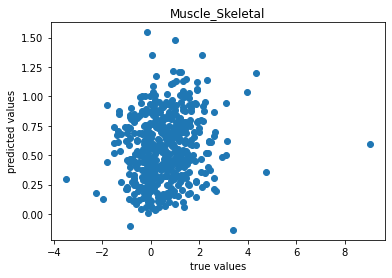

explained_variance_score for testing set 0.01618909488639564
mean squared error for testing set 1.0690842490847103
explained_variance_score for training set 0.8621922560620443
mean squared error for training set 0.40476959768811316
34 ************* Nerve_Tibial
train (2912, 74)
test (512, 74)


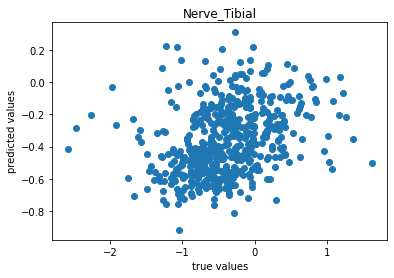

explained_variance_score for testing set 0.10383762485296233
mean squared error for testing set 0.5427633849870975
explained_variance_score for training set 0.8648407165766374
mean squared error for training set 0.21768693971025604
35 ************* Ovary
train (2855, 74)
test (509, 74)


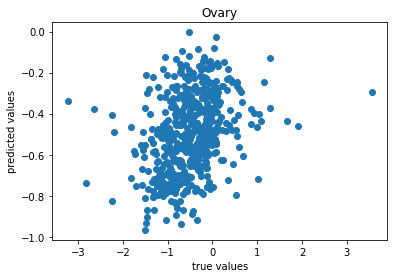

explained_variance_score for testing set 0.10282088393331668
mean squared error for testing set 0.5925105263262681
explained_variance_score for training set 0.859876576013016
mean squared error for training set 0.21959407486277072
36 ************* Pancreas
train (2725, 74)
test (476, 74)


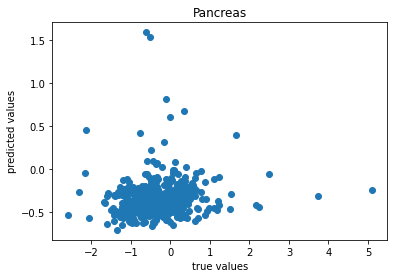

explained_variance_score for testing set -0.025623509614621343
mean squared error for testing set 0.7121768872045392
explained_variance_score for training set 0.8234290990936094
mean squared error for training set 0.28251865090913914
37 ************* Pituitary
train (2803, 74)
test (495, 74)


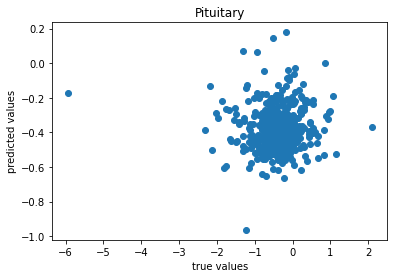

explained_variance_score for testing set -0.031144282689167246
mean squared error for testing set 0.5782073878597677
explained_variance_score for training set 0.8279570141962922
mean squared error for training set 0.23793447685475183
38 ************* Prostate
train (2876, 74)
test (505, 74)


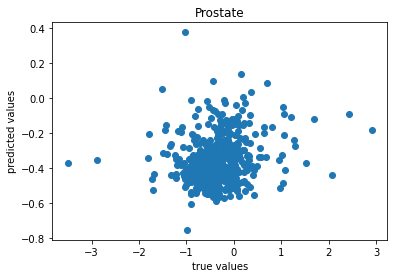

explained_variance_score for testing set 0.0336640703639256
mean squared error for testing set 0.5513730407555645
explained_variance_score for training set 0.8410169829486749
mean squared error for training set 0.1996225704708968
39 ************* Skin_Not_Sun_Exposed_Suprapubic
train (2900, 74)
test (498, 74)


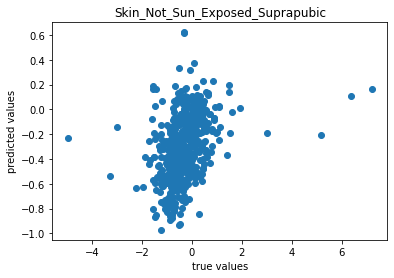

explained_variance_score for testing set 0.12283716422393254
mean squared error for testing set 0.8000567952788754
explained_variance_score for training set 0.8642437591683683
mean squared error for training set 0.2537682337331254
40 ************* Skin_Sun_Exposed_Lower_leg
train (2887, 74)
test (502, 74)


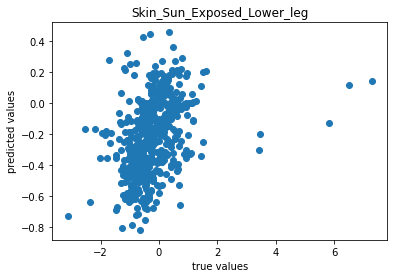

explained_variance_score for testing set 0.11031564524834991
mean squared error for testing set 0.8219985958906459
explained_variance_score for training set 0.8571161183550179
mean squared error for training set 0.26685248763425357
41 ************* Small_Intestine_Terminal_Ileum
train (2897, 74)
test (502, 74)


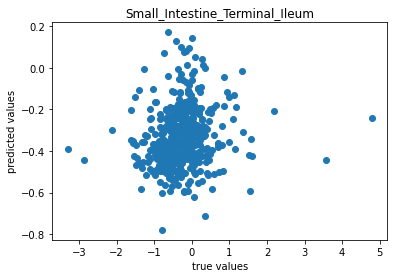

explained_variance_score for testing set 0.01327338747589002
mean squared error for testing set 0.6281597370526245
explained_variance_score for training set 0.823150183062785
mean squared error for training set 0.2456693507899407
42 ************* Spleen
train (2717, 74)
test (477, 74)


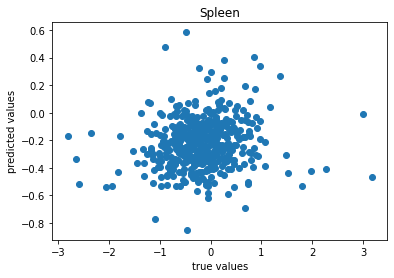

explained_variance_score for testing set -0.007539902893243244
mean squared error for testing set 0.6481067445435393
explained_variance_score for training set 0.8538612095095861
mean squared error for training set 0.2594370832379306
43 ************* Stomach
train (2922, 74)
test (513, 74)


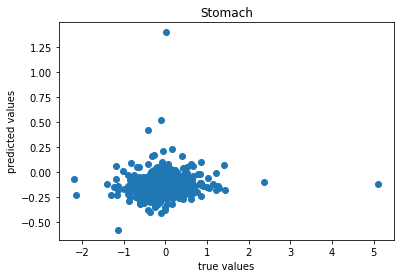

explained_variance_score for testing set -0.0036264502653677866
mean squared error for testing set 0.5168961629380588
explained_variance_score for training set 0.7977843140983396
mean squared error for training set 0.22123292757927207
44 ************* Testis
train (2623, 74)
test (457, 74)


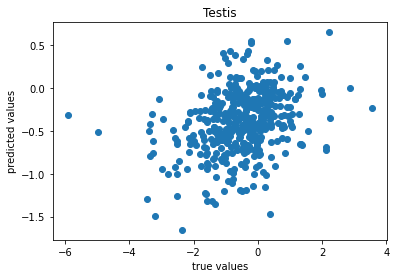

explained_variance_score for testing set 0.08926110025081246
mean squared error for testing set 1.0123250562833168
explained_variance_score for training set 0.8520999413250939
mean squared error for training set 0.4402979368992234
45 ************* Thyroid
train (2907, 74)
test (502, 74)


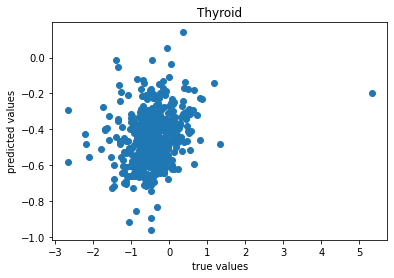

explained_variance_score for testing set 0.05857761702718811
mean squared error for testing set 0.552206569962173
explained_variance_score for training set 0.8510042445309074
mean squared error for training set 0.21389505613260482
46 ************* Uterus
train (2886, 74)
test (501, 74)


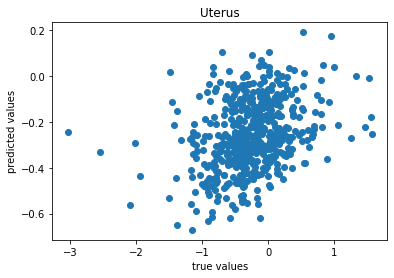

explained_variance_score for testing set 0.10326101459499204
mean squared error for testing set 0.5031278712327231
explained_variance_score for training set 0.8500081183679441
mean squared error for training set 0.19588761823835416
47 ************* Vagina
train (2924, 74)
test (510, 74)


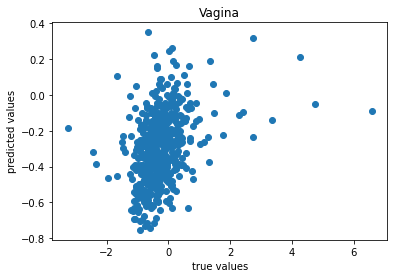

explained_variance_score for testing set 0.11320376641124874
mean squared error for testing set 0.7094729182455211
explained_variance_score for training set 0.8464516512261937
mean squared error for training set 0.22642540194164273
48 ************* Whole_Blood
train (2292, 74)
test (405, 74)


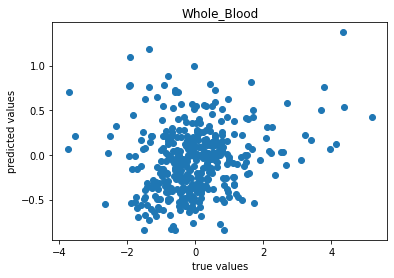

explained_variance_score for testing set 0.01688456839212993
mean squared error for testing set 1.1361143496501795
explained_variance_score for training set 0.8621259867081812
mean squared error for training set 0.4347594913400855


In [97]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


def train(i):   
    model = RandomForestRegressor(max_depth=20)

    idx_tr= np.where(X_train['tissue'] == i)[0]
    X_tr=np.array(X_train)[idx_tr]
    y_tr=np.array(y_train)[idx_tr]
    print("train", X_tr.shape)

    idx_te= np.where(X_test['tissue'] == i)[0]
    X_te=np.array(X_test)[idx_te]
    y_te=np.array(y_test)[idx_te]
    print("test", X_te.shape)

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    plt.scatter(y_te,y_pred)
    plt.title(tissues[i])
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.show()
    

    exp=explained_variance_score(y_te, y_pred)
    print("explained_variance_score for testing set",exp)

    msqe = mean_squared_error(y_te,y_pred,squared=False)
    print("mean squared error for testing set",msqe)

    y_pred2 = model.predict(X_tr)

    exp2=explained_variance_score(y_tr, y_pred2)
    print("explained_variance_score for training set",exp2)

    msqe2 = mean_squared_error(y_tr,y_pred2,squared=False)
    print("mean squared error for training set",msqe2)

    return exp, msqe, exp2, msqe2,y_pred

results_explained_variance_te = []
results_rmse_te=[]

results_explained_variance_tr = []
results_rmse_tr=[]

y_pred_abs_E=[]

for i in range(49):
    print(i,'*************',tissues[i])
    res1, res2, res3, res4, res5= train(i)
    results_explained_variance_te.append(res1)
    results_rmse_te.append(res2)
    results_explained_variance_tr.append(res3)
    results_rmse_tr.append(res4)
    y_pred_abs_E.append(res5)

## PLOT y_true vs y_pred fol all tissues

(136998,)
(136998,)


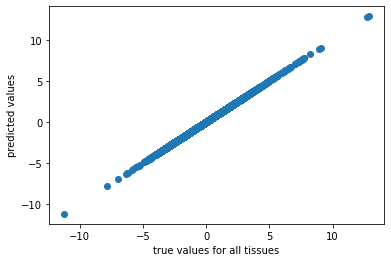

[0. 0. 0. ... 0. 0. 0.]


In [138]:
y_tr_abs_E=[]

for i in range(49):
  idx_tr= np.where(X_train['tissue'] == i)[0]
  y_tr=np.array(y_train)[idx_tr]
  y_tr_abs_E.append(y_tr)

y_tr_abs_E = np.hstack(y_tr_abs_E)
print(y_tr_abs_E.shape)
y_pred_abs_E = np.hstack(y_pred_abs_E)
print(y_pred_abs_E.shape)


plt.scatter(y_tr_abs_E,y_pred_abs_E)
plt.xlabel("true values for all tissues")
plt.ylabel("predicted values")
plt.show()

print(y_pred_abs_E-y_tr_abs_E)

explained variance on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


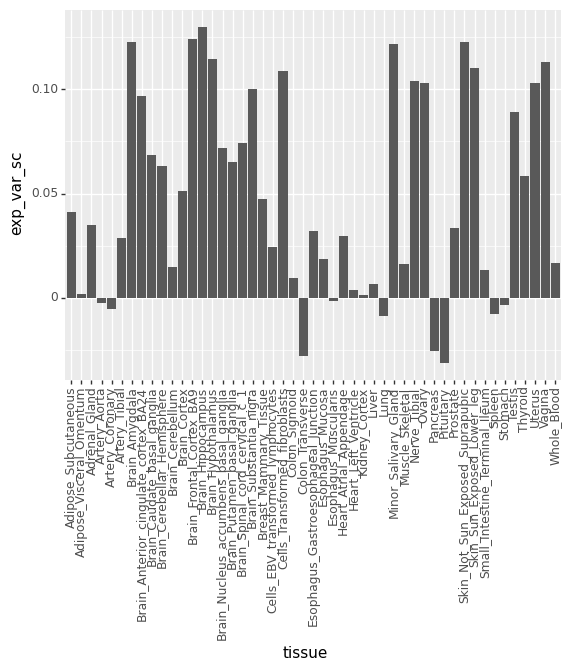

<ggplot: (8781300605357)>

In [139]:
print("explained variance on test set")
res1 = {'exp_var_sc':results_explained_variance_te,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

explained variance on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


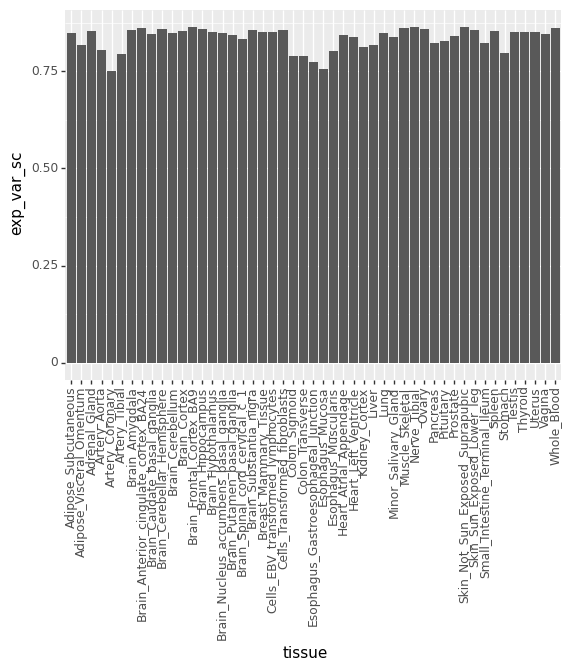

<ggplot: (8781275402657)>

In [140]:
print("explained variance on train set")
res1 = {'exp_var_sc':results_explained_variance_tr,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

root mean squared error on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


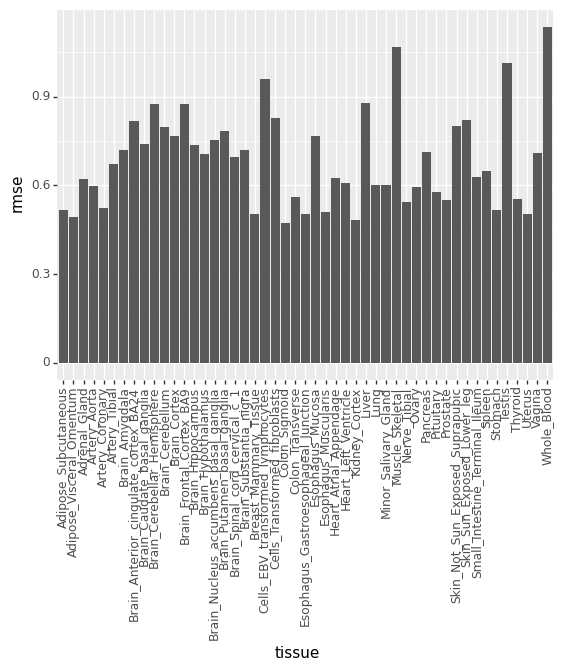

<ggplot: (8781268239369)>

In [141]:
print("root mean squared error on test set")
res2 = {'rmse':results_rmse_te,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

root mean squared error on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


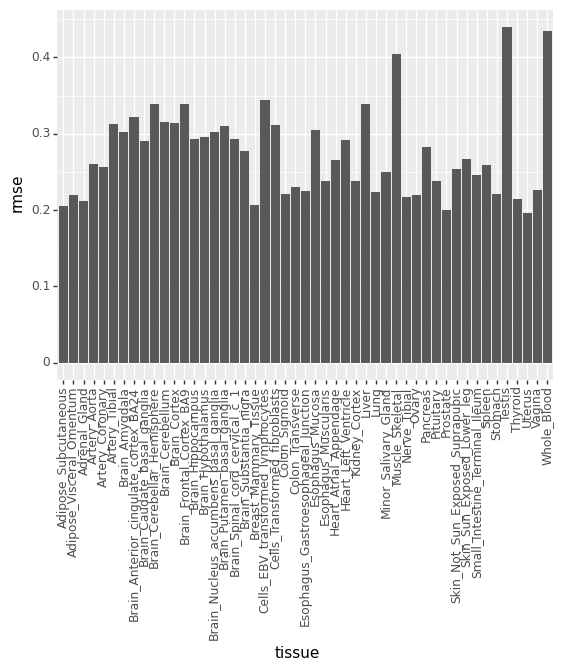

<ggplot: (8781315289981)>

In [142]:
print("root mean squared error on train set")
res2 = {'rmse':results_rmse_tr,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))


## Folding energy + relative half life

In [143]:
tissue_hl_E_2=tissue_hl_E
tissue_hl_E_2['mean_hl'] = tissue_hl2.loc[:, tissues].mean(axis=1)
tissue_hl_E_2

tissue_hl_E_2.loc[:, tissues] = tissue_hl2.loc[:, tissues].sub(tissue_hl2['mean_hl'], axis=0)

df2 = tissue_hl_E_2
cols=[col for col in df2 if col != 'Name']+['Name']
df2=df2[cols]
tissues = df2.columns[:49]
tissues
for i in range (49):  #49
  df2=df2.rename(columns={tissues[i]:i})
df2


df2=pd.melt(df2,id_vars=df2.columns[49:], value_vars=df2.columns[0:49], var_name="tissue",value_name="relative_half_life")
df2

a=len(df2)
df2 = df2.loc[df2.loc[:, ['relative_half_life']].dropna().index]
print(len(df2)/a)
df2


0.9404667944525876


,cds,5_utr,3_utr,all,chromosome,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,...,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,mean_hl,energy_3utr,energy_5utr,Name,tissue,relative_half_life
0,ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGA...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,CCAGCCAGGGGCAGGCCCCTGATGCCCGGAAGCTCCTGCGTGCATC...,ACGGGGGCGGGCCCGCGGTGACGTCGGGAGGGCAGCGACGCGCGGA...,chr7,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,...,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,7.703588e-17,-168.3,-30.6,ENST00000000233.5,0,0.134752
1,ATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTAC...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,ATTGCACTTTATATGTCCAGCCTCTTCCTCAGTCCCCCAAACCAAA...,CCGGGAGCGGTCAGGCGCGTGACCCCGCGTGACCGGGGTGCGCGAG...,chr12,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,...,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,8.987520e-17,-393.6,-64.6,ENST00000000412.3,0,-0.376770
2,ATGTCCAGCCAGGTGGTGGGCATTGAGCCTCTCTACATCAAGGCAG...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,GGCAAGGGGTGGGACTGGTGGGGGTTCTGGCAGGACCTGCCTAGCA...,AAGCAGCCGGCGGCGCCGCCGAGTGAGGGGACGCGGCGCGGTGGGG...,chr11,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,...,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,-1.359457e-17,-332.9,-125.5,ENST00000000442.6,0,-0.726338
3,ATGACAGCCGAGGAGATGAAGGCGACCGAGAGCGGGGCGCAGTCGG...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,CCCCTCTCCACCAGCCCTACTCCTGCGGCTGCCTGCCCCCCAGTCT...,GAGCCGCTCCTGACCCACCTACCCCAGCTCTCGCGCCGCGTGCAGA...,chr12,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,...,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,9.516197e-17,-673.5,-74.2,ENST00000001008.4,0,-0.216329
4,ATGCTCTTTGAGGGCTTGGATCTGGTGTCGGCGCTGGCCACCCTCG...,

In [145]:
df3 = df2
df3 = df2.drop(columns=['cds','3_utr', '5_utr','all','chromosome','Name'])

X = df3.drop(['relative_half_life'], axis=1)
y = df3['relative_half_life']

chrom_val=['chr2', 'chr3','chr4']
chrom_test=['chr1','chr8','chr9']


X_train = X[~(df2.chromosome.isin(chrom_test)| df2.chromosome.isin(chrom_val))]
X_test  = X[df2.chromosome.isin(chrom_test)]
X_val   = X[df2.chromosome.isin(chrom_val)]
y_train = y[~(df2.chromosome.isin(chrom_test)| df2.chromosome.isin(chrom_val))]
y_test  = y[df2.chromosome.isin(chrom_test)]
y_val   = y[df2.chromosome.isin(chrom_val)]

In [146]:
df3

,log_3_utr_length,log_5_utr_length,log_cds_length,gc_content_5_utr,gc_content_cds,gc_content_3_utr,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,AGG,AGT,ATA,ATC,ATG,ATT,CAA,CAC,CAG,CAT,CCA,CCC,CCG,CCT,CGA,CGC,CGG,CGT,CTA,CTC,CTG,CTT,GAA,GAC,GAG,GAT,GCA,GCC,GCG,GCT,GGA,GGC,GGG,GGT,GTA,GTC,GTG,GTT,TAA,TAC,TAG,TAT,TCA,TCC,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,mean_hl,energy_3utr,energy_5utr,tissue,relative_half_life
0,8.668885,7.276124,9.079485,0.837662,0.561111,0.591133,0.005556,0.022222,0.055556,0.011111,0.022222,0.038889,0.005556,0.011111,0.000000,0.011111,0.000000,0.005556,0.005556,0.027778,0.033333,0.016667,0.011111,0.016667,0.050000,0.000000,0.005556,0.011111,0.000000,0.005556,0.000000,0.016667,0.038889,0.000000,0.005556,0.027778,0.072222,0.000000,0.022222,0.044444,0.033333,0.022222,0.005556,0.022222,0.011111,0.011111,0.005556,0.038889,0.016667,0.011111,0.011111,0.022222,0.038889,0.005556,0.0,0.016667,0.0,0.011111,0.005556,0.011111,0.005556,0.005556,0.0,0.000000,0.022222,0.011111,0.005556,0.022222,0.011111,0.016667,7.703588e-17,-168.3,-30.6,0,0.134752
1,10.505812,8.876517,9.700440,0.620469,0.498195,0.414315,0.036101,0.025271,0.014440,0.021661,0.010830,0.003610,0.003610,0.018051,0.007220,0.018051,0.014440,0.010830,0.000000,0.032491,0.021661,0.000000,0.007220,0.021661,0.025271,0.003610,0.010830,0.003610,0.000000,0.014440,0.010830,0.000000,0.003610,0.018051,0.021661,0.014440,0.039711,0.007220,0.028881,0.025271,0.050542,0.025271,0.025271,0.010830,0.003610,0.014440,0.018051,0.025271,0.028881,0.018051,0.014440,0.010830,0.050542,0.014440,0.0,0.018051,0.0,0.014440,0.018051,0.014440,0.000000,0.010830,0.0,0.018051,0.014440,0.014440,0.014440,0.025271,0.007220,0.025271,8.987520e-17,-393.6,-64.6,0,-0.376770
2,9.594325,7.426265,10.310613,0.836257,0.648542,0.584197,0.004728,0.002364,0.044917,0.004728,0.007092,0.014184,0.002364,0.002364,0.002364,0.018913,0.004728,0.002364,0.000000,0.016548,0.021277,0.004728,0.002364,0.014184,0.028369,0.004728,0.018913,0.021277,0.011820,0.023641,0.007092,0.018913,0.035461,0.000000,0.009456,0.030733,0.085106,0.002364,0.014184,0.026005,0.078014,0.011820,0.018913,0.059102,0.004728,0.028369,0.007092,0.037825,0.033097,0.016548,0.002364,0.011820,0.056738,0.004728,0.0,0.009456,0.0,0.011820,0.009456,0.014184,0.007092,0.007092,0.0,0.014184,0.004728,0.011820,0.002364,0.021277,0.004728,0.002364,-1.359457e-17,-332.9,-125.5,0,-0.726338
3,9.453271,7.554589,10.428360,0.775401,0.530864,0.504286,0.023965,0.019608,0.071895,0.015251,0.013072,0.010893,0.006536,0.008715,0.004357,0.017429,0.006536,0.010893,0.006536,0.021786,0.023965,0.015251,0.004357,0.010893,0.041394,0.006536,0.008715,0.019608,0.002179,0.004357,0.006536,0.013072,0.013072,0.000000,0.008715,0.017429,0.045752,0.006536,0.043573,0.028322,0.084967,0.013072,0.017429,0.043573,0.006536,0.023965,0.015251,0.023965,0.017429,0.013072,0.002179,0.010893,0.028322,0.004357,0.0,0.017429,0.0,0.017429,0.006536,0.010893,0.002179,0.013072,0.0,0.006536,0.008715,0.004357,0.006536,0.013072,0.002179,0.028322,9.516197e-17,-673.5,-74.2,0,-0.216329
4,11.545930,7.679480,10.585901,0.720588,0.630859,0.525928,0.003906,0.015625,0.050781,0.003906,0.011719,0.031250,0.013672,0.005859,0.000000,0.035156,0.001953,0.009766,0.001953,0.039062,0.021484,0.007812,0.000000,0.023438,0.042969,0.007812,0.000000,0.029297,0.007812,0.005859,0.000000,0.035156,0.025391,0.000000,0.000000,0.023438,0.101562,0.003906,0.000000,0.035156,0.060547,0.011719,0.000000,0.037109,0.015625,0.005859,0.003906,0.048828,0.011719,0.007812,0.000000,0.023438,0.041016,0.000000,0.0,0.015625,0.0,0.005859,0.001953,0.015625,0.007812,0.001953,0.0,0.013672,0.011719,0.000000,0.000000,0.039062,0.011719,0.011719,-1.327441e-17,-1142.8,-54.8,0,-0.069316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


0 ************* Adipose_Subcutaneous
train (2919, 74)
test (511, 74)


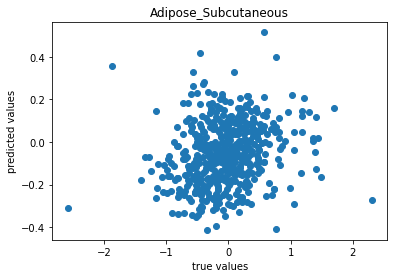

explained_variance_score for testing set 0.037777313150632374
mean squared error for testing set 0.5188012202244936
explained_variance_score for training set 0.8459998786159614
mean squared error for training set 0.20689371231307935
1 ************* Adipose_Visceral_Omentum
train (2930, 74)
test (512, 74)


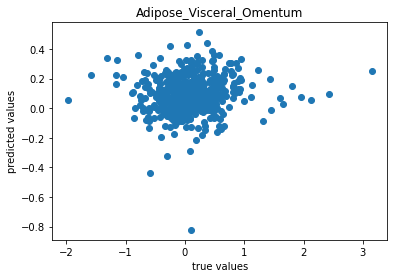

explained_variance_score for testing set -0.021330191720687175
mean squared error for testing set 0.497804868078638
explained_variance_score for training set 0.8152764016000449
mean squared error for training set 0.22162512112503954
2 ************* Adrenal_Gland
train (2859, 74)
test (494, 74)


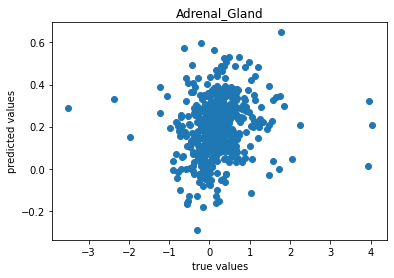

explained_variance_score for testing set 0.020964699417748145
mean squared error for testing set 0.6263354854169796
explained_variance_score for training set 0.8504512151592316
mean squared error for training set 0.2137458417709904
3 ************* Artery_Aorta
train (2881, 74)
test (504, 74)


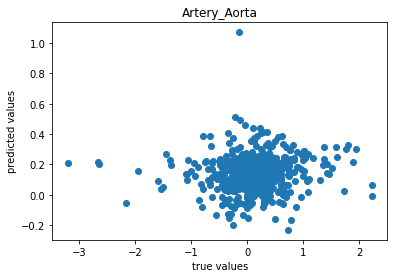

explained_variance_score for testing set -0.007756819109864033
mean squared error for testing set 0.5987010859690866
explained_variance_score for training set 0.8008988803837024
mean squared error for training set 0.26311591239538784
4 ************* Artery_Coronary
train (2919, 74)
test (510, 74)


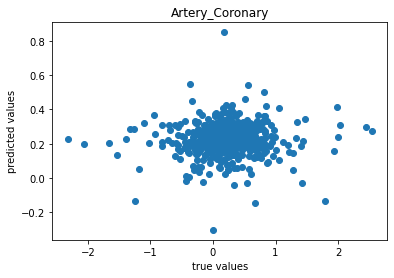

explained_variance_score for testing set -0.01570001780198571
mean squared error for testing set 0.524988291172653
explained_variance_score for training set 0.7569280139410296
mean squared error for training set 0.2528858273155648
5 ************* Artery_Tibial
train (2903, 74)
test (506, 74)


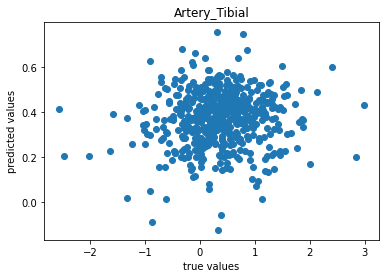

explained_variance_score for testing set 0.003271136080776449
mean squared error for testing set 0.6790144262031805
explained_variance_score for training set 0.798378050330445
mean squared error for training set 0.3088470521876128
6 ************* Brain_Amygdala
train (2694, 74)
test (485, 74)


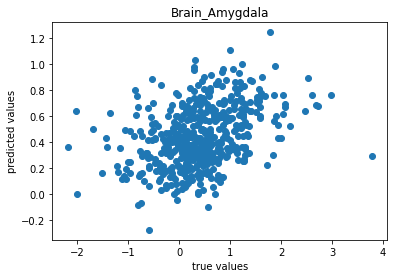

explained_variance_score for testing set 0.13397791321920216
mean squared error for testing set 0.7142178665143215
explained_variance_score for training set 0.8513693026129805
mean squared error for training set 0.30671268522171563
7 ************* Brain_Anterior_cingulate_cortex_BA24
train (2730, 74)
test (488, 74)


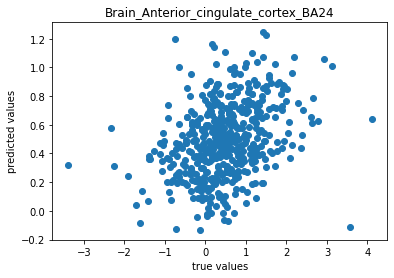

explained_variance_score for testing set 0.11458107133400208
mean squared error for testing set 0.8109217133956512
explained_variance_score for training set 0.8596562686521235
mean squared error for training set 0.32442429908858894
8 ************* Brain_Caudate_basal_ganglia
train (2756, 74)
test (490, 74)


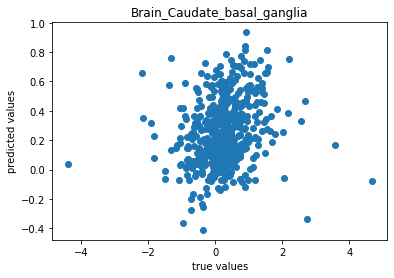

explained_variance_score for testing set 0.041966933928751504
mean squared error for testing set 0.7490812678369794
explained_variance_score for training set 0.8417772871154097
mean squared error for training set 0.29380178839589355
9 ************* Brain_Cerebellar_Hemisphere
train (2608, 74)
test (474, 74)


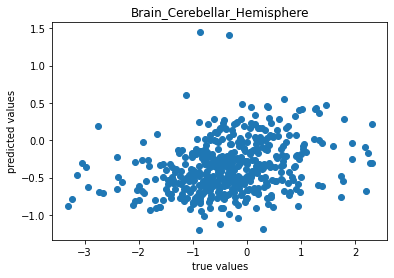

explained_variance_score for testing set 0.0715472233038964
mean squared error for testing set 0.8702091962707276
explained_variance_score for training set 0.8604089526447846
mean squared error for training set 0.33791929570861895
10 ************* Brain_Cerebellum
train (2634, 74)
test (476, 74)


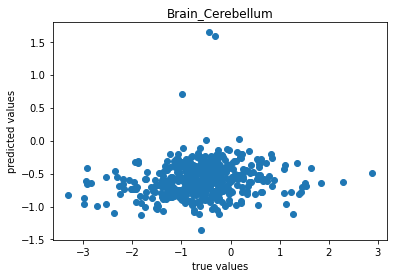

explained_variance_score for testing set -0.004710249461446603
mean squared error for testing set 0.8054053099253738
explained_variance_score for training set 0.8464557064821325
mean squared error for training set 0.31845484848760836
11 ************* Brain_Cortex
train (2744, 74)
test (493, 74)


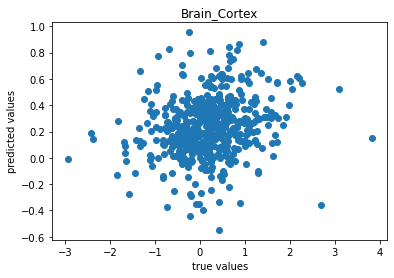

explained_variance_score for testing set 0.03895246673439767
mean squared error for testing set 0.7718246176567867
explained_variance_score for training set 0.8501829748680465
mean squared error for training set 0.31823471931992414
12 ************* Brain_Frontal_Cortex_BA9
train (2751, 74)
test (493, 74)


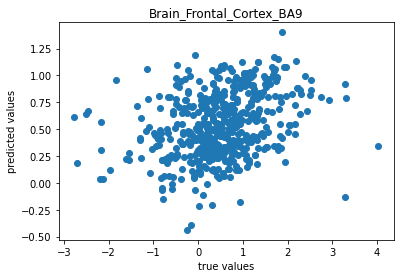

explained_variance_score for testing set 0.09935407889860648
mean squared error for testing set 0.888310438794207
explained_variance_score for training set 0.8677048684749065
mean squared error for training set 0.33531842570681164
13 ************* Brain_Hippocampus
train (2740, 74)
test (494, 74)


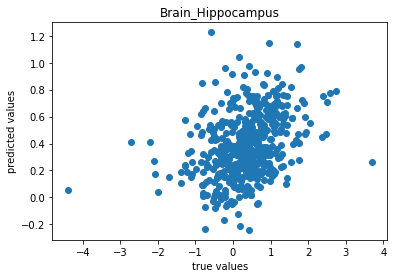

explained_variance_score for testing set 0.11822016354941967
mean squared error for testing set 0.7403138859235292
explained_variance_score for training set 0.8558381113401945
mean squared error for training set 0.2960293209707682
14 ************* Brain_Hypothalamus
train (2764, 74)
test (495, 74)


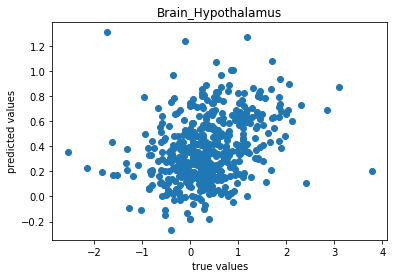

explained_variance_score for testing set 0.10662999075084678
mean squared error for testing set 0.71022816175905
explained_variance_score for training set 0.8520454224161467
mean squared error for training set 0.29517291635500603
15 ************* Brain_Nucleus_accumbens_basal_ganglia
train (2733, 74)
test (494, 74)


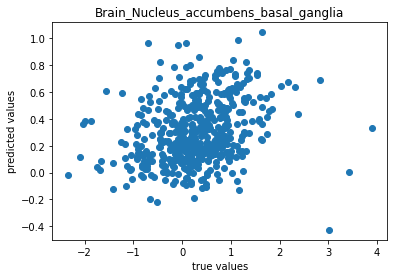

explained_variance_score for testing set 0.07616729150699886
mean squared error for testing set 0.7502147904478422
explained_variance_score for training set 0.8529483876064999
mean squared error for training set 0.29906520150966187
16 ************* Brain_Putamen_basal_ganglia
train (2674, 74)
test (476, 74)


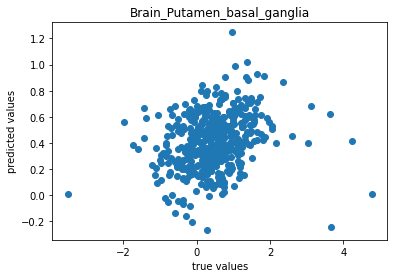

explained_variance_score for testing set 0.061540646730323
mean squared error for testing set 0.7858756904306519
explained_variance_score for training set 0.8505192971674064
mean squared error for training set 0.302844584715816
17 ************* Brain_Spinal_cord_cervical_c_1
train (2800, 74)
test (498, 74)


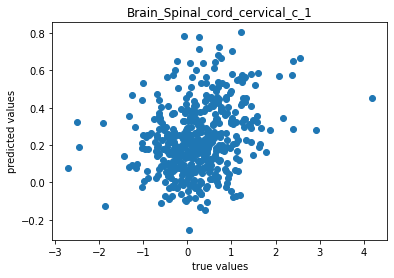

explained_variance_score for testing set 0.07363159444852041
mean squared error for testing set 0.6960907018356488
explained_variance_score for training set 0.8422985003807494
mean squared error for training set 0.285342641336221
18 ************* Brain_Substantia_nigra
train (2762, 74)
test (490, 74)


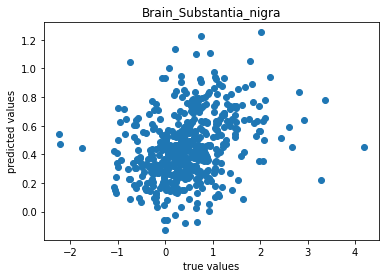

explained_variance_score for testing set 0.09679711692461623
mean squared error for testing set 0.7222024765028566
explained_variance_score for training set 0.8516901587603427
mean squared error for training set 0.28157802571087515
19 ************* Breast_Mammary_Tissue
train (2945, 74)
test (510, 74)


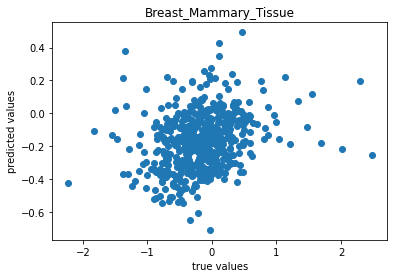

explained_variance_score for testing set 0.07620663251406612
mean squared error for testing set 0.49671547768200347
explained_variance_score for training set 0.8488469190812535
mean squared error for training set 0.20900307809360744
20 ************* Cells_EBV_transformed_lymphocytes
train (2460, 74)
test (412, 74)


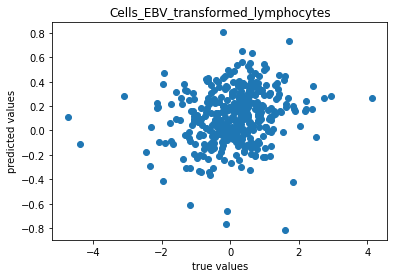

explained_variance_score for testing set 0.038026222702220114
mean squared error for testing set 0.9522011968928853
explained_variance_score for training set 0.8492097177186753
mean squared error for training set 0.3462296442191154
21 ************* Cells_Transformed_fibroblasts
train (2633, 74)
test (468, 74)


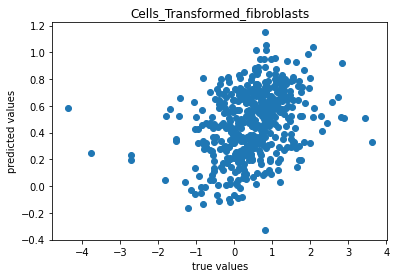

explained_variance_score for testing set 0.10197357558106834
mean squared error for testing set 0.8290533330441976
explained_variance_score for training set 0.8582230656731696
mean squared error for training set 0.30985917267479135
22 ************* Colon_Sigmoid
train (2918, 74)
test (512, 74)


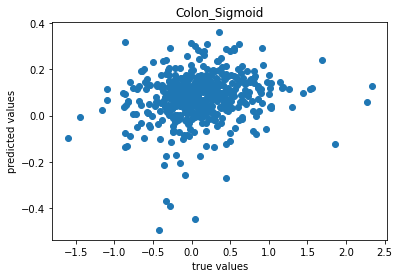

explained_variance_score for testing set 0.028577277391049427
mean squared error for testing set 0.46796145972691766
explained_variance_score for training set 0.7820403174164697
mean squared error for training set 0.22458652700587992
23 ************* Colon_Transverse
train (2925, 74)
test (513, 74)


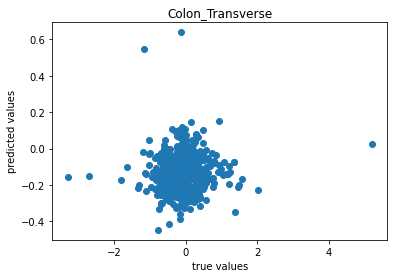

explained_variance_score for testing set -0.013287901784551526
mean squared error for testing set 0.5547516153290768
explained_variance_score for training set 0.7965771472344279
mean squared error for training set 0.22694946674790487
24 ************* Esophagus_Gastroesophageal_Junction
train (2924, 74)
test (512, 74)


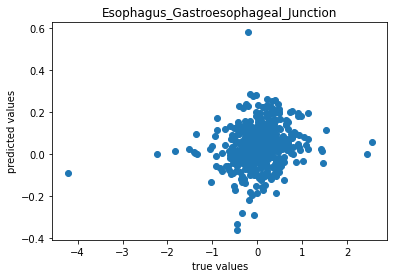

explained_variance_score for testing set 0.036602679703816476
mean squared error for testing set 0.5025343218633854
explained_variance_score for training set 0.7607328210795447
mean squared error for training set 0.23192727413464145
25 ************* Esophagus_Mucosa
train (2885, 74)
test (504, 74)


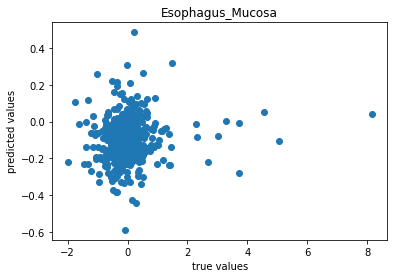

explained_variance_score for testing set 0.008421717259351258
mean squared error for testing set 0.7712447878655001
explained_variance_score for training set 0.7596592994640624
mean squared error for training set 0.3026711507825964
26 ************* Esophagus_Muscularis
train (2923, 74)
test (511, 74)


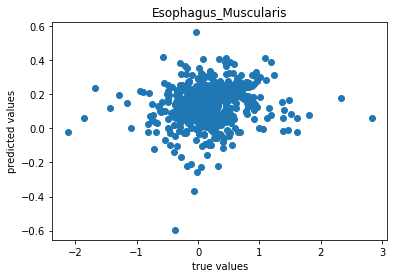

explained_variance_score for testing set 0.0008446406010000906
mean squared error for testing set 0.5087247648078052
explained_variance_score for training set 0.797609477126351
mean squared error for training set 0.2401525009683649
27 ************* Heart_Atrial_Appendage
train (2822, 74)
test (494, 74)


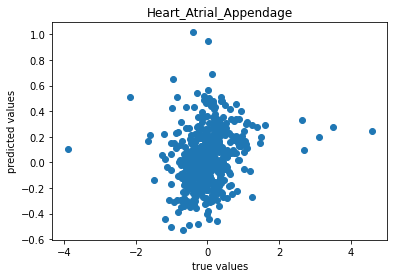

explained_variance_score for testing set 0.0275806045444833
mean squared error for testing set 0.6240073384032611
explained_variance_score for training set 0.8452682123311213
mean squared error for training set 0.26480202936365493
28 ************* Heart_Left_Ventricle
train (2719, 74)
test (489, 74)


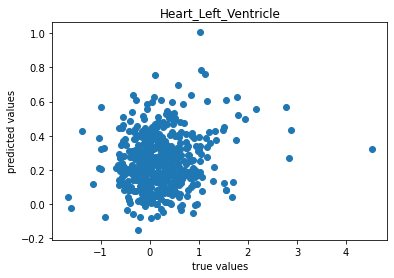

explained_variance_score for testing set 0.019570211572848883
mean squared error for testing set 0.603967604415129
explained_variance_score for training set 0.8368372343628409
mean squared error for training set 0.2935426160317148
29 ************* Kidney_Cortex
train (2797, 74)
test (492, 74)


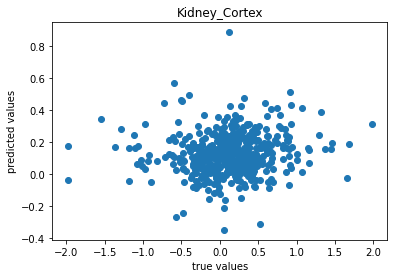

explained_variance_score for testing set -0.010936160071823409
mean squared error for testing set 0.48452287547578093
explained_variance_score for training set 0.8143384090939324
mean squared error for training set 0.23769558749057065
30 ************* Liver
train (2610, 74)
test (452, 74)


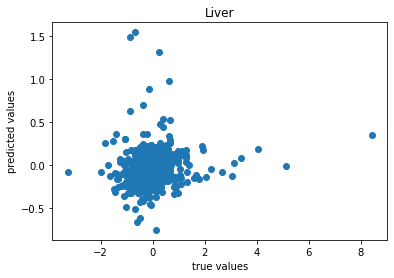

explained_variance_score for testing set 0.00027455924022479206
mean squared error for testing set 0.8815355901519888
explained_variance_score for training set 0.8192869604156588
mean squared error for training set 0.33654771201160916
31 ************* Lung
train (2917, 74)
test (510, 74)


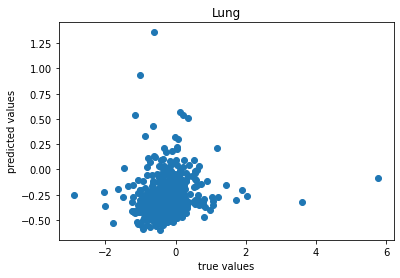

explained_variance_score for testing set -0.01734332354101209
mean squared error for testing set 0.605236282612561
explained_variance_score for training set 0.8523257709545204
mean squared error for training set 0.22135698544257099
32 ************* Minor_Salivary_Gland
train (2867, 74)
test (499, 74)


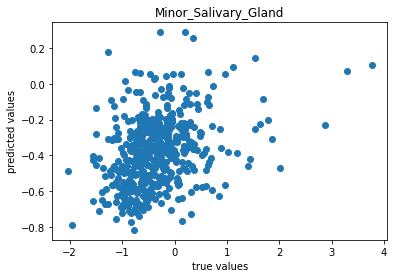

explained_variance_score for testing set 0.10374404498951306
mean squared error for testing set 0.60705320920951
explained_variance_score for training set 0.8325972203522051
mean squared error for training set 0.2556510509381199
33 ************* Muscle_Skeletal
train (2726, 74)
test (485, 74)


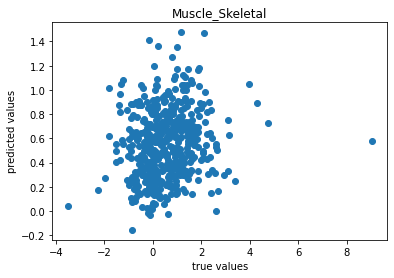

explained_variance_score for testing set 0.013073818523649972
mean squared error for testing set 1.0707030441444
explained_variance_score for training set 0.861909163248413
mean squared error for training set 0.4051839460315092
34 ************* Nerve_Tibial
train (2912, 74)
test (512, 74)


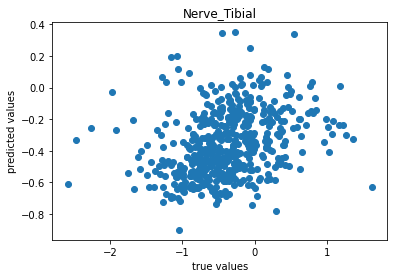

explained_variance_score for testing set 0.0892832951654754
mean squared error for testing set 0.5470976523624097
explained_variance_score for training set 0.8655703483931579
mean squared error for training set 0.21709879290934805
35 ************* Ovary
train (2855, 74)
test (509, 74)


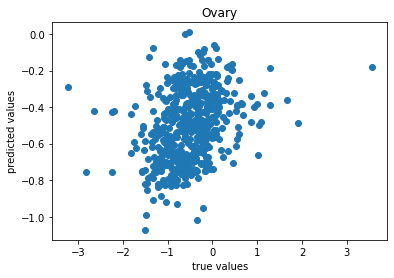

explained_variance_score for testing set 0.10212885459019594
mean squared error for testing set 0.5927422896854815
explained_variance_score for training set 0.8584829634027507
mean squared error for training set 0.2206928615224822
36 ************* Pancreas
train (2725, 74)
test (476, 74)


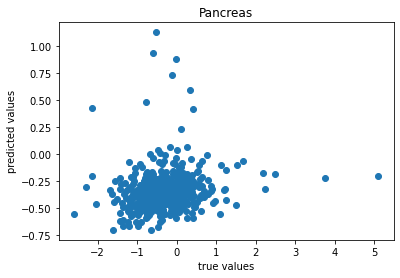

explained_variance_score for testing set 0.012427189162175445
mean squared error for testing set 0.6989564034354132
explained_variance_score for training set 0.8280284028996432
mean squared error for training set 0.2788149801280131
37 ************* Pituitary
train (2803, 74)
test (495, 74)


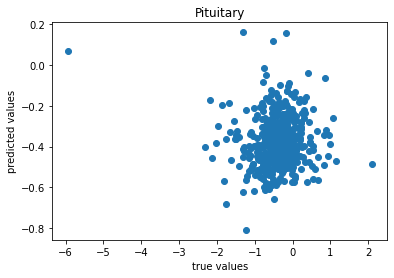

explained_variance_score for testing set -0.04107737999632466
mean squared error for testing set 0.581141548054965
explained_variance_score for training set 0.8328210388771797
mean squared error for training set 0.2345584626313762
38 ************* Prostate
train (2876, 74)
test (505, 74)


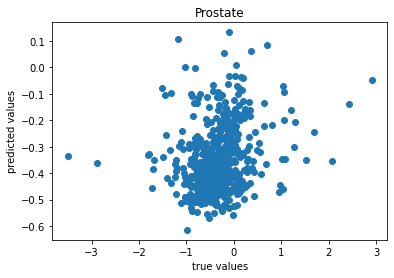

explained_variance_score for testing set 0.04768659304615486
mean squared error for testing set 0.5473156093603943
explained_variance_score for training set 0.8475704608078403
mean squared error for training set 0.19545052344795374
39 ************* Skin_Not_Sun_Exposed_Suprapubic
train (2900, 74)
test (498, 74)


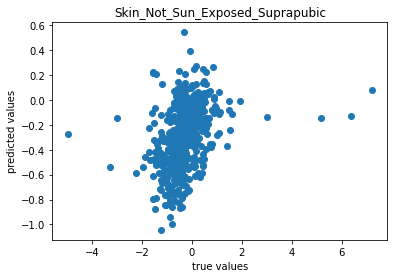

explained_variance_score for testing set 0.11551678620646932
mean squared error for testing set 0.8033103061335355
explained_variance_score for training set 0.866178673616364
mean squared error for training set 0.25196046663257565
40 ************* Skin_Sun_Exposed_Lower_leg
train (2887, 74)
test (502, 74)


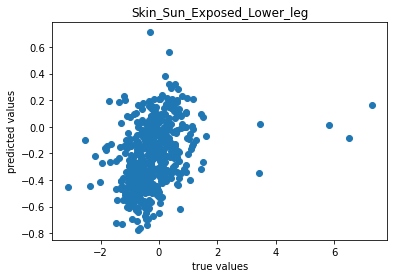

explained_variance_score for testing set 0.10728998532048617
mean squared error for testing set 0.8233982715467144
explained_variance_score for training set 0.855856488473343
mean squared error for training set 0.2680096541733259
41 ************* Small_Intestine_Terminal_Ileum
train (2897, 74)
test (502, 74)


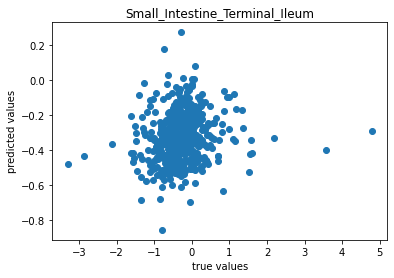

explained_variance_score for testing set 0.018305961043177055
mean squared error for testing set 0.6265054333662701
explained_variance_score for training set 0.825285888013264
mean squared error for training set 0.24419713676672114
42 ************* Spleen
train (2717, 74)
test (477, 74)


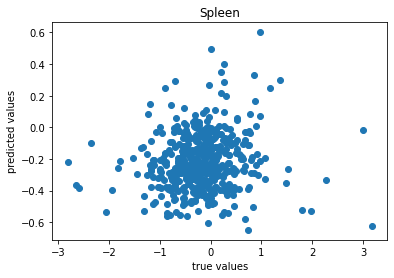

explained_variance_score for testing set -0.016892084763417747
mean squared error for testing set 0.6507655806629845
explained_variance_score for training set 0.8538985985695775
mean squared error for training set 0.25942356004490885
43 ************* Stomach
train (2922, 74)
test (513, 74)


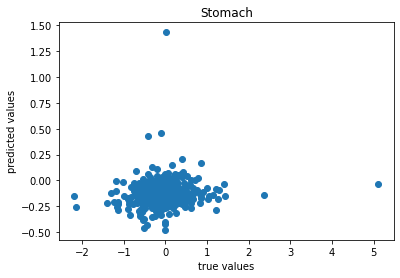

explained_variance_score for testing set 0.0031042942106394023
mean squared error for testing set 0.5151207032383851
explained_variance_score for training set 0.7910752577283909
mean squared error for training set 0.22487214270100134
44 ************* Testis
train (2623, 74)
test (457, 74)


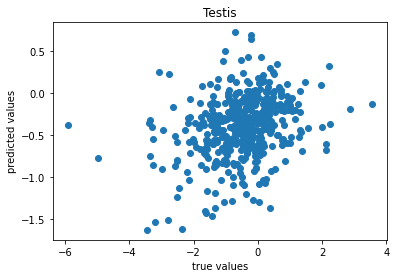

explained_variance_score for testing set 0.07520085162494605
mean squared error for testing set 1.0194975604024832
explained_variance_score for training set 0.8542397391634722
mean squared error for training set 0.43710155627606395
45 ************* Thyroid
train (2907, 74)
test (502, 74)


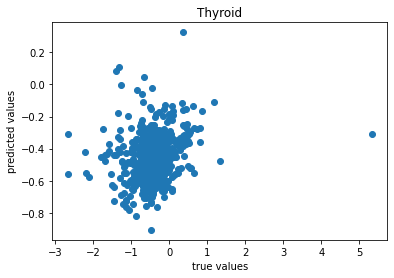

explained_variance_score for testing set 0.04587148516174788
mean squared error for testing set 0.5559187400795531
explained_variance_score for training set 0.841449495779275
mean squared error for training set 0.2206432566186008
46 ************* Uterus
train (2886, 74)
test (501, 74)


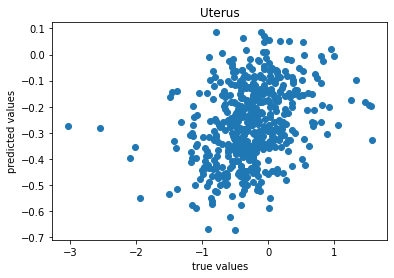

explained_variance_score for testing set 0.101725256458851
mean squared error for testing set 0.5034747883734351
explained_variance_score for training set 0.8511361465052423
mean squared error for training set 0.19514834565572942
47 ************* Vagina
train (2924, 74)
test (510, 74)


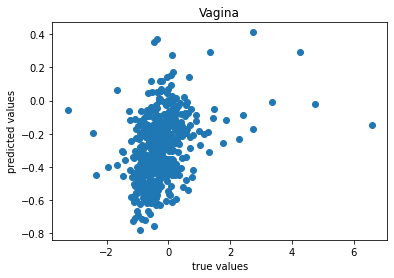

explained_variance_score for testing set 0.10967542004952757
mean squared error for testing set 0.7107776250602074
explained_variance_score for training set 0.8466505249289693
mean squared error for training set 0.22624923305991787
48 ************* Whole_Blood
train (2292, 74)
test (405, 74)


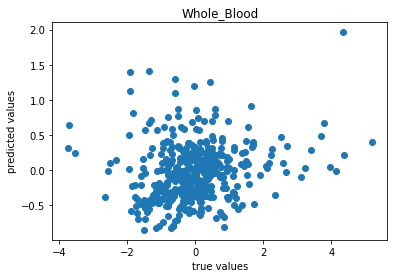

explained_variance_score for testing set -0.005142502363626011
mean squared error for testing set 1.1483866655581627
explained_variance_score for training set 0.8527995814439469
mean squared error for training set 0.4492747279076151


In [147]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


def train(i):   
    model = RandomForestRegressor(max_depth=20)

    idx_tr= np.where(X_train['tissue'] == i)[0]
    X_tr=np.array(X_train)[idx_tr]
    y_tr=np.array(y_train)[idx_tr]
    print("train", X_tr.shape)

    idx_te= np.where(X_test['tissue'] == i)[0]
    X_te=np.array(X_test)[idx_te]
    y_te=np.array(y_test)[idx_te]
    print("test", X_te.shape)

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    plt.scatter(y_te,y_pred)
    plt.title(tissues[i])
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.show()
    

    exp=explained_variance_score(y_te, y_pred)
    print("explained_variance_score for testing set",exp)

    msqe = mean_squared_error(y_te,y_pred,squared=False)
    print("mean squared error for testing set",msqe)

    y_pred2 = model.predict(X_tr)

    exp2=explained_variance_score(y_tr, y_pred2)
    print("explained_variance_score for training set",exp2)

    msqe2 = mean_squared_error(y_tr,y_pred2,squared=False)
    print("mean squared error for training set",msqe2)

    return exp, msqe, exp2, msqe2,y_pred

results_explained_variance_te = []
results_rmse_te=[]

results_explained_variance_tr = []
results_rmse_tr=[]

y_pred_abs_E=[]

for i in range(49):
    print(i,'*************',tissues[i])
    res1, res2, res3, res4, res5= train(i)
    results_explained_variance_te.append(res1)
    results_rmse_te.append(res2)
    results_explained_variance_tr.append(res3)
    results_rmse_tr.append(res4)
    y_pred_abs_E.append(res5)

(24110,)
(24110,)


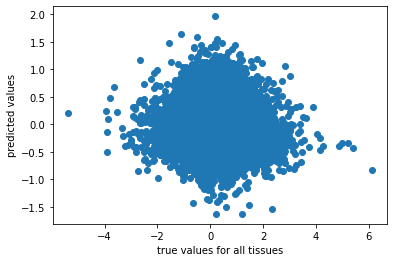

[-0.37667887  0.32925113  0.68737942 ... -0.20347586 -0.29368823
 -1.04245015]


In [150]:
y_tr_abs_E=[]

for i in range(49):
  idx_te= np.where(X_test['tissue'] == i)[0]
  y_te=np.array(y_train)[idx_te]
  y_tr_abs_E.append(y_te)

y_tr_abs_E = np.hstack(y_tr_abs_E)
print(y_tr_abs_E.shape)


y_pred_abs_E = np.hstack(y_pred_abs_E)
print(y_pred_abs_E.shape)


plt.scatter(y_tr_abs_E,y_pred_abs_E)
plt.xlabel("true values for all tissues")
plt.ylabel("predicted values")
plt.show()

print(y_pred_abs_E-y_tr_abs_E)

explained variance on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


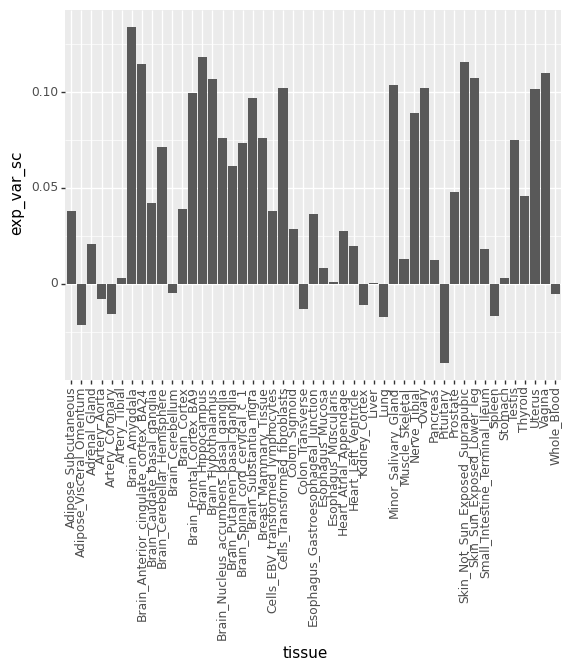

<ggplot: (8781297862393)>

In [153]:
print("explained variance on test set")
res1 = {'exp_var_sc':results_explained_variance_te,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))


explained variance on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


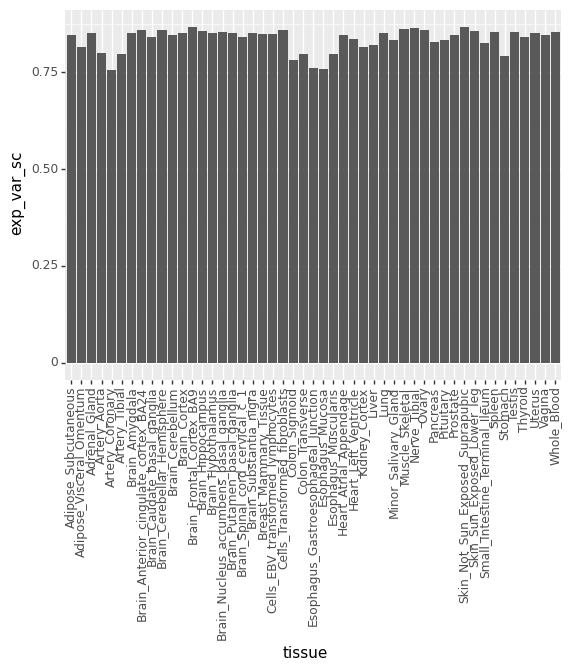

<ggplot: (8781275205433)>

In [154]:
print("explained variance on train set")
res1 = {'exp_var_sc':results_explained_variance_tr,'tissue':tissues}
eval = pd.DataFrame(res1)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

root mean squared error on test set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


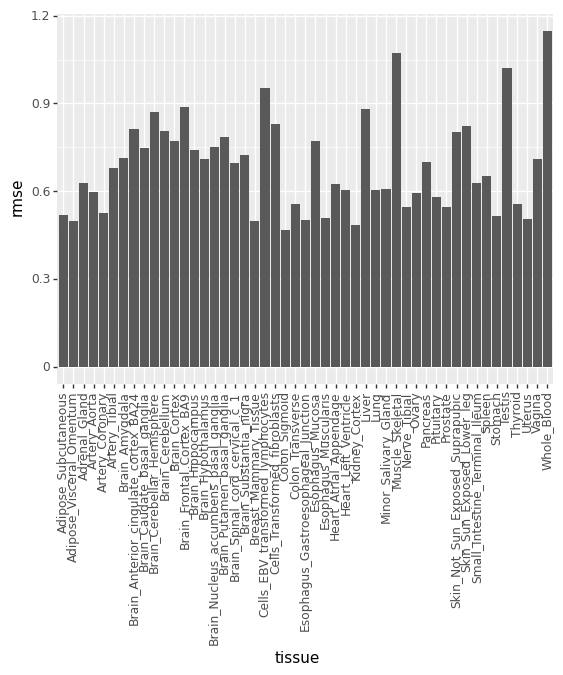

<ggplot: (8781314081529)>

In [155]:
print("root mean squared error on test set")
res2 = {'rmse':results_rmse_te,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))

root mean squared error on train set


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


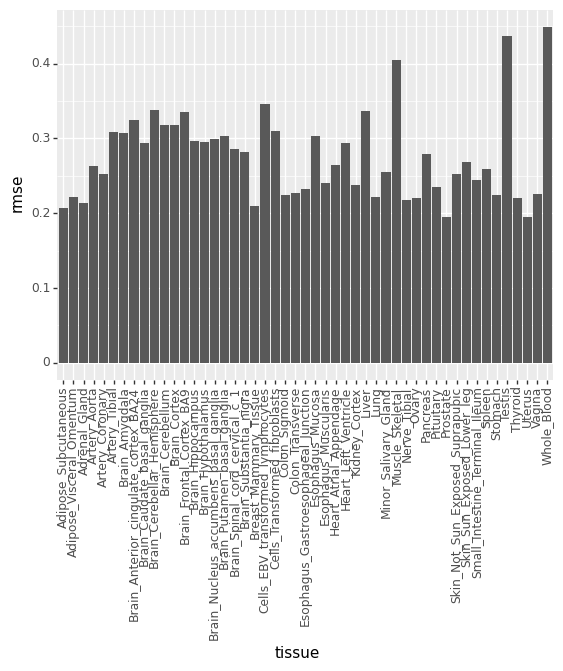

<ggplot: (8781303852241)>

In [156]:
print("root mean squared error on train set")
res2 = {'rmse':results_rmse_tr,'tissue':tissues}
eval = pd.DataFrame(res2)
import plotnine as p9
p9.ggplot(eval, p9.aes('tissue', 'rmse')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))
